In [1]:
import pylab as plt
import matplotlib.pyplot as plt
import numpy as np
import h5py
import shutil
import pdb
import datetime
import os
from operator import truediv
import operator
from scipy.optimize import curve_fit
import matplotlib.cm as cm
from scipy.optimize import leastsq

%pylab
%matplotlib inline
%load_ext autoreload
%autoreload 2



Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


In [194]:
corr_list = [4,11,17,22,27,28,29]
freq_phase = np.linspace(400,800,1024)
colors=['r','g','b','k','c','y','m']
legend_crosscorr = ["(0,4) A63","(1,4) A00","(2,4) A48","(3,4) A31","(5,4) B00","(6,4) B63","(7,4) B48"]

freq=512
num =14

In [195]:
def mag(tot_frames,corr_files):
        tot_magnitude = np.zeros((tot_frames, len(corr_list), len(freq_phase[50:990])))
        tot_magnitude_ref = np.zeros((tot_frames, 2, len(freq_phase[50:990])))
        x=0
        for corr_file in corr_files:
                for i in range(len(corr_list)):
                        frames =  corr_file['vis'][:].shape[0]
                        tot_magnitude[x:x+frames,i,:] = (np.sqrt(corr_file['vis'][:][:,corr_list[i],50:990]['imag'].astype(np.float)**2 + corr_file['vis'][:][:,corr_list[i],50:990]['real'].astype(np.float)**2))
                tot_magnitude_ref[x:x+frames,0,:] = np.sqrt(corr_file['vis'][:][:,26,50:990]['imag'].astype(np.float)**2 + corr_file['vis'][:][:,27,50:990]['real'].astype(np.float)**2)
                tot_magnitude_ref[x:x+frames,1,:] = corr_file['vis'][:][:,27,50:990]
                x = x + frames

        return tot_magnitude,tot_magnitude_ref

In [196]:
def gain_freq(corr_files,tot_frames,visibility, visibility_ref):
        x=0
        gain_1 = np.zeros((tot_frames, len(corr_list), len(freq_phase[50:990])))
        for corr_file in corr_files:
                frames = corr_file['vis'][:].shape[0]
                gain = np.zeros((frames, len(corr_list), len(freq_phase[50:990])))
                for i in range(len(corr_list)):
                        gain_1[x:frames+x,i,:] = 20*np.log10(np.sqrt(corr_file['vis'][:][:,corr_list[i],50:990]['imag'].astype(np.float)**2 + corr_file['vis'][:][:,corr_list[i],50:990]['real'].astype(np.float)**2)/(np.sqrt(corr_file['vis'][:][:,26,50:990]['imag'].astype(np.float)**2 + corr_file['vis'][:][:,26,50:990]['real'].astype(np.float)**2)))
                x=frames+x

        return gain_1[:,:,::-1]

In [197]:
def delay_unwrap(tot_frames,corr_files):
        delay = np.zeros((tot_frames,len(corr_list)))
        #phi = np.zeros((frames, len(corr_list), len(freq_phase[20:990])))# not taking some frequency bins
        kk=0
        delay_freq_bad_frame = np.zeros((len(corr_list),len(freq_phase[50:990])))
        for corr_file in corr_files:
                vis = corr_file['vis'][:][:,corr_list,50:990]
                frames = corr_file['vis'][:].shape[0]
                vis_abs =  np.sqrt((vis['imag']).astype(np.float)**2+(vis['real']).astype(np.float)**2)
                vis_abs =  np.sqrt((vis['imag']).astype(np.float)**2+(vis['real']).astype(np.float)**2)
                phi = np.arctan2((vis['imag']),(vis['real']))
                unwrap_phase_1 = np.unwrap(phi)
                unwrap_phase = unwrap_phase_1[:,::-1]/(2*np.pi)
                slope = [[0 for x in range(len(corr_list))] for y in range(frames)]
                for j in range(len(corr_list)):
                        slope_1 = []
                        for i in range(frames):
                                slope[i],b = np.polyfit(freq_phase[50:990]*10**6,unwrap_phase[i][j][:],1)
                                if slope[i]<0:
                                        slope[i] = slope[i]*(-1.0)
                        delay[kk:kk+frames,j] = slope
                kk=kk+frames
                #pdb.set_trace()
        return np.array(delay),unwrap_phase #

In [198]:
def get_timestamp(tot_frames,corr_files):
        cpu_cycle = np.zeros(tot_frames)
        x = 0
        for corr_file in corr_files:
                frame = corr_file['vis'][:].shape[0]
                timestamp = corr_file['timestamp']
                cpu_cycle[x:x+frame] = [time[1] for time in timestamp]
                x=x+frame
        return cpu_cycle


In [199]:
def data(chan):
        number_of_frame = corr_file['vis'][:].shape[0]
        print('Number of frames:' + str(number_of_frame))
        return number_of_frame

In [200]:
para=3
def quadratic(x,*p):
        freq_reqd = freq
        return p[0]*x**2 + p[1]*x+  p[2]

In [201]:
def sinusoidal(x,*p):
        freq_reqd = freq
        return p[0]*x + p[1]*(np.cos(2*np.pi*p[2]))#+ np.cos(2*np.pi*4/(0.84*3*10**2/freq_reqd)))

In [262]:
source_dir = ['C:/Users/sidhant/Desktop/data/20170407T194716Z_stone_corr/', 'C:/Users/sidhant/Desktop/data/20170410T180753Z_stone_corr/','C:/Users/sidhant/Desktop/data/20170414T020912Z_stone_corr/' ,'C:/Users/sidhant/Desktop/data/20170430T010748Z_stone_corr_one_file_deleted/', 'C:/Users/sidhant/Desktop/data/20170519T221539Z_stone_corr/' ,'C:/Users/sidhant/Desktop/data/20170525T174006Z_stone_corr_two_files_delated/'] #Apr 7-apr 10, #Apr 10-APR 13 #Apr 29 - May14
tot_frames = 0
corr_files=[]
for d in range(len(source_dir)):
    source_directory = source_dir[d]
    source_name = os.path.realpath(source_directory).split('/')[-1]
    active_dir = source_dir[d]
    all_file_names = os.listdir(active_dir)
    data_file_names = []
    for file_name in all_file_names:
        if ('.lock' not in file_name) and ('.h5' in file_name):
                data_file_names.append(file_name)
    data_file_names.sort()
    for file_name in data_file_names:
        corr_files.append(h5py.File(active_dir+file_name,'r'))

for corr_file in corr_files:
    frames = data(corr_list)
    tot_frames = tot_frames + frames
    

print(corr_files)
visibility, visibility_ref = mag(tot_frames,corr_files)
delay, unwrap_phase = delay_unwrap(tot_frames,corr_files)
# the return gain is in db/logrithmic
gain_all_db = gain_freq(corr_files,tot_frames,visibility, visibility_ref)

time_stamp = get_timestamp(tot_frames,corr_files)
date_stamp = [datetime.datetime.fromtimestamp(time)+datetime.timedelta(hours = 7) for time in time_stamp]

Number of frames:360
Number of frames:61
Number of frames:360
Number of frames:119
Number of frames:360
Number of frames:360
Number of frames:360
Number of frames:264
Number of frames:360
Number of frames:360
Number of frames:54
Number of frames:360
[<HDF5 file "00000000_0000.h5" (mode r)>, <HDF5 file "00216004_0000.h5" (mode r)>, <HDF5 file "00000000_0000.h5" (mode r)>, <HDF5 file "00216003_0000.h5" (mode r)>, <HDF5 file "00000000_0000.h5" (mode r)>, <HDF5 file "00000000_0000.h5" (mode r)>, <HDF5 file "00648000_0000.h5" (mode r)>, <HDF5 file "00863999_0000.h5" (mode r)>, <HDF5 file "00000000_0000.h5" (mode r)>, <HDF5 file "00216003_0000.h5" (mode r)>, <HDF5 file "00432001_0000.h5" (mode r)>, <HDF5 file "00216003_0000.h5" (mode r)>]


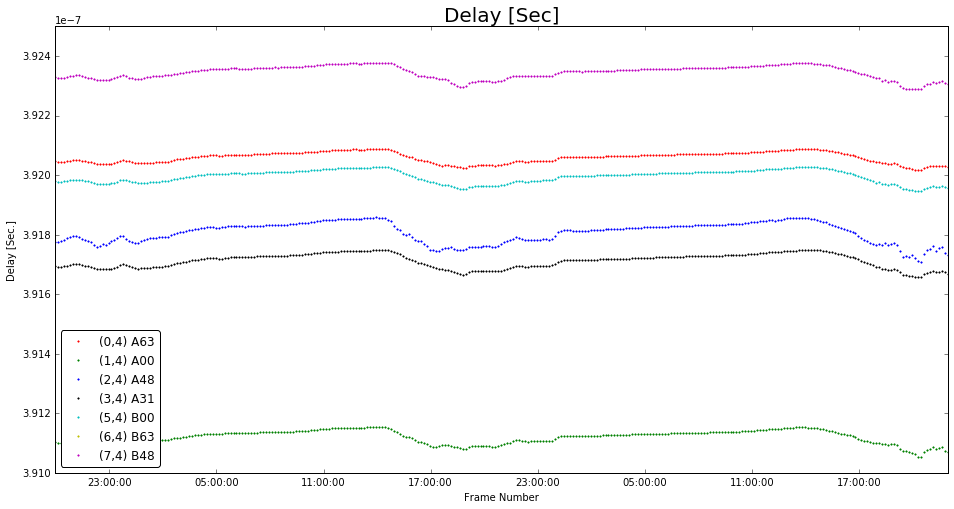

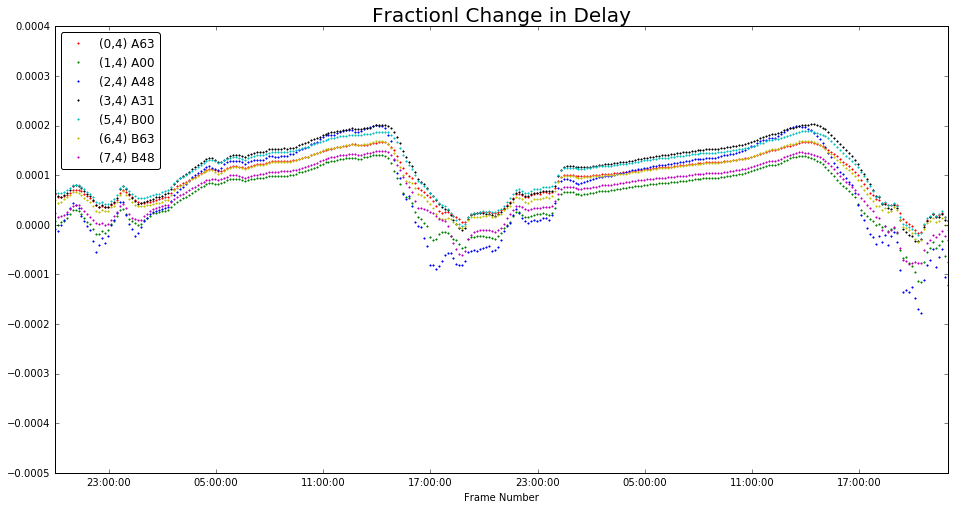

In [263]:
figure(figsize(16,8))
#plt.title('Delay [Sec.]', size=20)
plt.ylabel('Delay [Sec.]', size =10)
plt.xlabel('Frame Number', size=10)
k=1; dd=1; k=0

for i in range (len(corr_list)):  
    #print(i)
    plt.plot(date_stamp,delay[:,i], '.', color = colors[k], label = str(legend_crosscorr[k]), markersize = 3)
    plt.title('Delay [Sec]', size=20)
    legend(loc='best', numpoints=1, fancybox=True)
    plt.xlim(date_stamp[0],date_stamp[300])
    plt.ylim(3.91*10**-7, 3.925*10**-7)
    k=k+1

figure(figsize(16,8))
k=0
for i in range (len(corr_list)): 
    #print(np.mean(delay[:,i]))
    plt.plot(date_stamp,(delay[:,i] - np.mean(delay[:,i]))/np.mean(delay[:,i]), '.', color = colors[k], label = str(legend_crosscorr[k]), markersize = 3)
    plt.title('Fractionl Change in Delay', size=20)
    plt.xlabel('Frame Number', size=10)
    legend(loc='best', numpoints=1, fancybox=True)
    plt.xlim(date_stamp[0],date_stamp[300])
    k=k+1

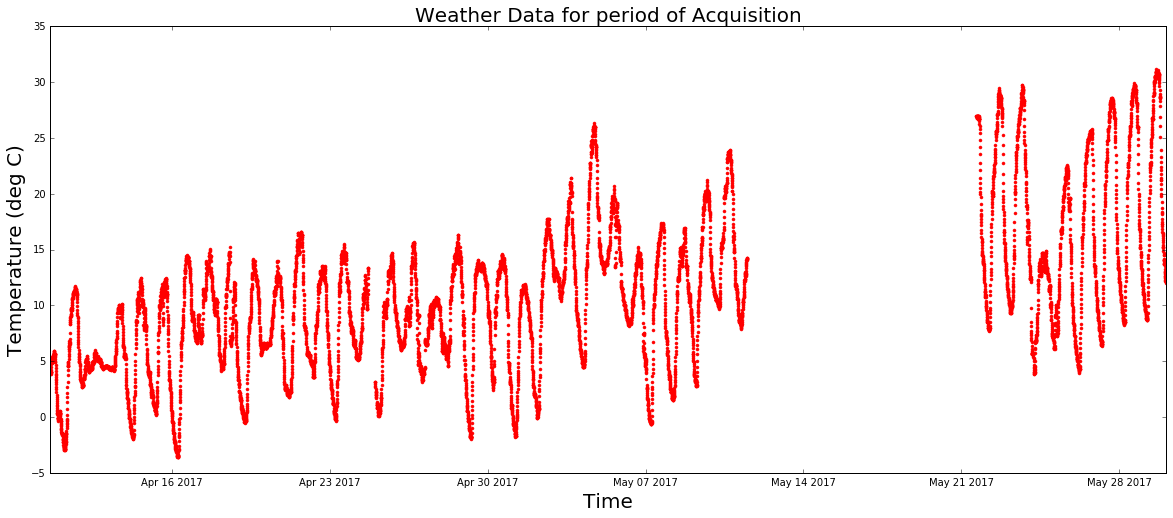

In [204]:
from IPython.display import Image
Image(filename='weather_data.png')

C:\Users\sidhant\Anaconda3\envs\py3k\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


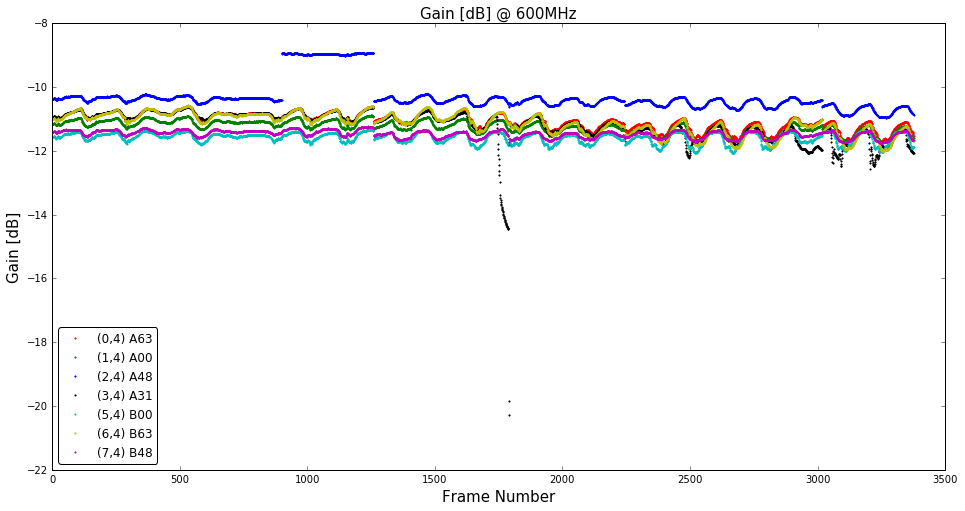

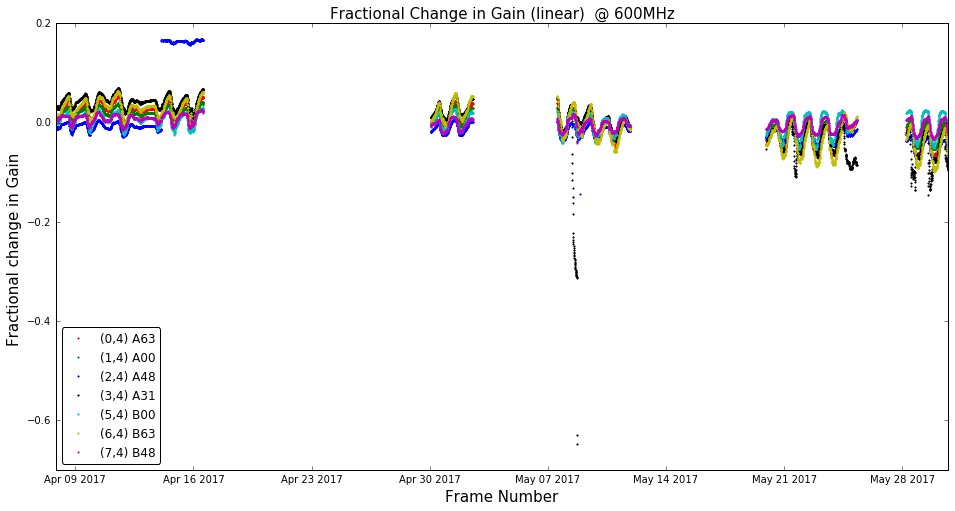

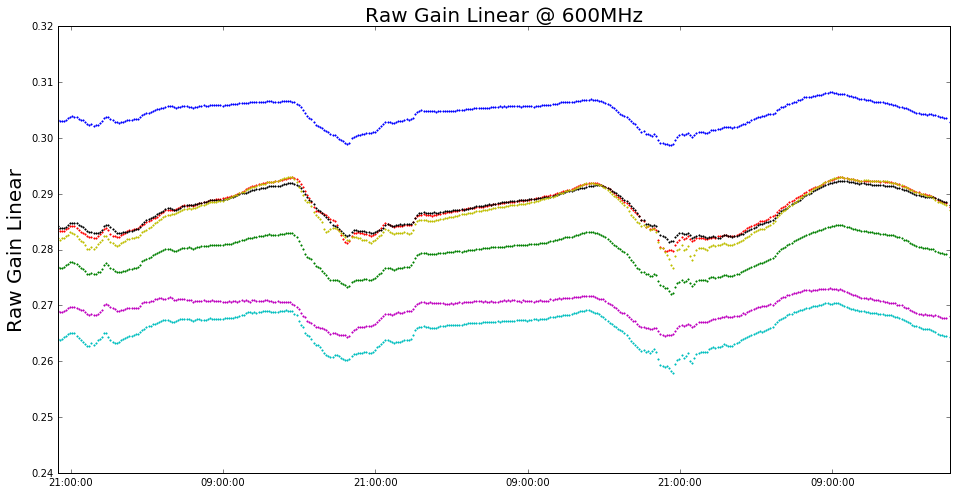

In [304]:
figure(figsize(16,8))
plt.title('Gain [dB] @ 600MHz', size=15)
plt.ylabel('Gain [dB]', size =15)
plt.xlabel('Frame Number', size=15)
dd=1; k=0
for i in range(len(corr_list)):
    plt.plot(gain_all_db[:,i,freq], '.', color = colors[k], label = str(legend_crosscorr[k]), markersize = 3)
    legend(loc='best', numpoints=1, fancybox=True)
    k=k+1

figure(figsize(16,8))
k=0
gain_all = 10**(gain_all_db/20)
for i in range(len(corr_list)):
    plt.plot(date_stamp,(gain_all[:,i,freq] - np.mean(gain_all[:,i,freq]))/np.mean(gain_all[:,i,freq]) , '.', color = colors[k], label = str(legend_crosscorr[k]), markersize = 3)
    legend(loc='best', numpoints=1, fancybox=True)
    plt.title('Fractional Change in Gain (linear)  @ 600MHz', size=15)
    plt.ylabel('Fractional change in Gain ', size =15)
    plt.xlabel('Frame Number', size=15)
    k=k+1

k=0
plt.figure()
for i in range(len(corr_list)):
    plt.plot(date_stamp,gain_all[:,i,freq],'.',color = colors[k] , markersize = 3)
    legend(loc='best', numpoints=1, fancybox=True)
    plt.title('Raw Gain Linear @ 600MHz', size=20)
    plt.ylabel('Raw Gain Linear', size =20)
    #plt.xlabel('Frame Number', size=20)
    plt.xlim(date_stamp[0],date_stamp[421])
    plt.ylim(0.24,0.32)
    
    
    k=k+1   

421
479
360
984
774
360
421
479
360
984
774
360
421
479
360
984
774
360
421
479
360
984
774
360
421
479
360
984
774
360
421
479
360
984
774
360
421
479
360
984
774
360


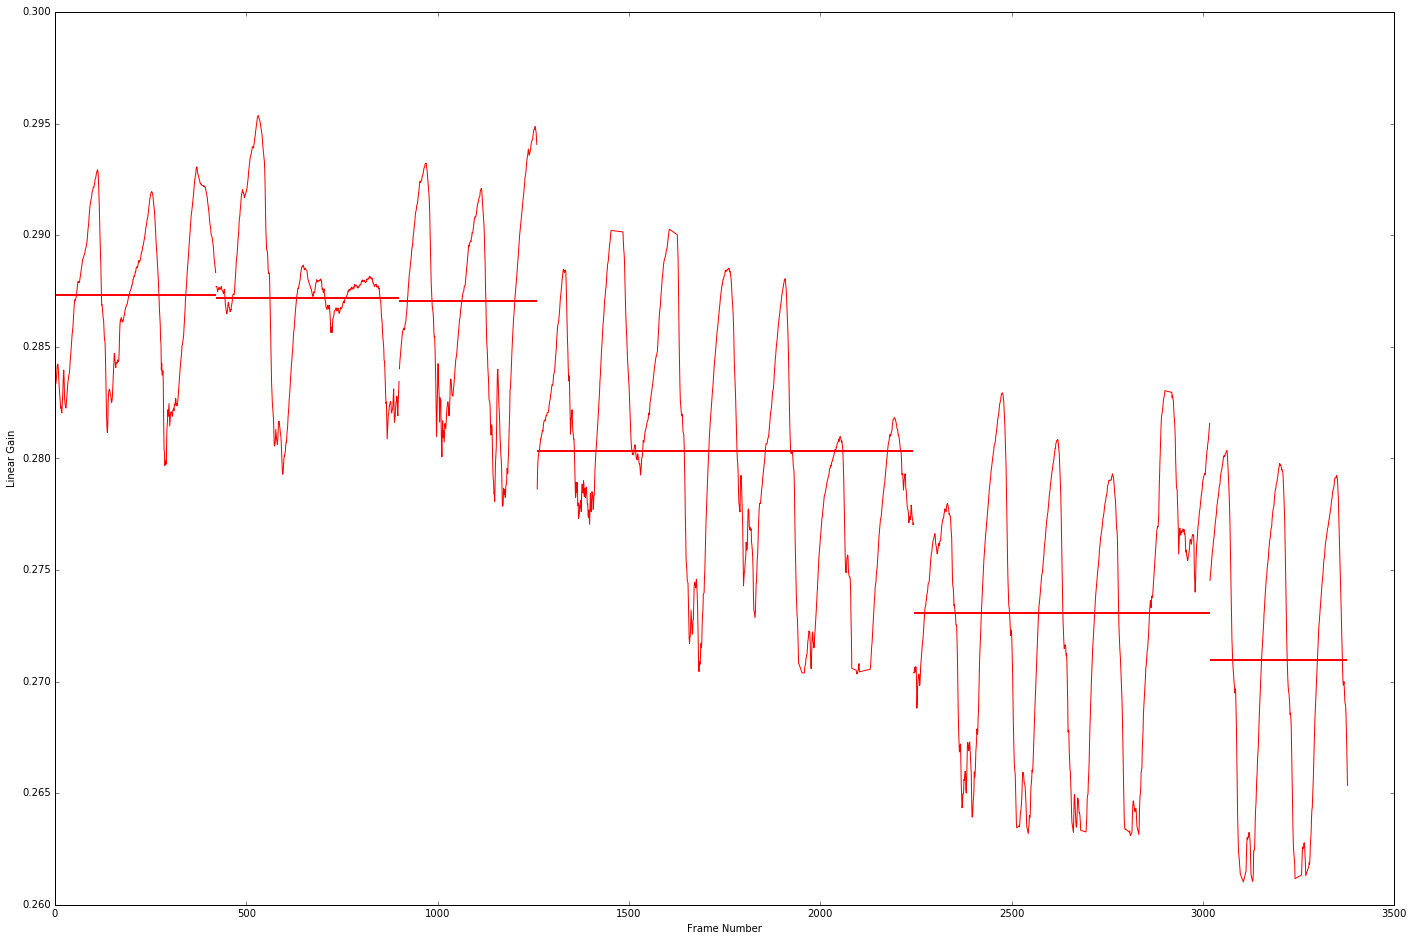

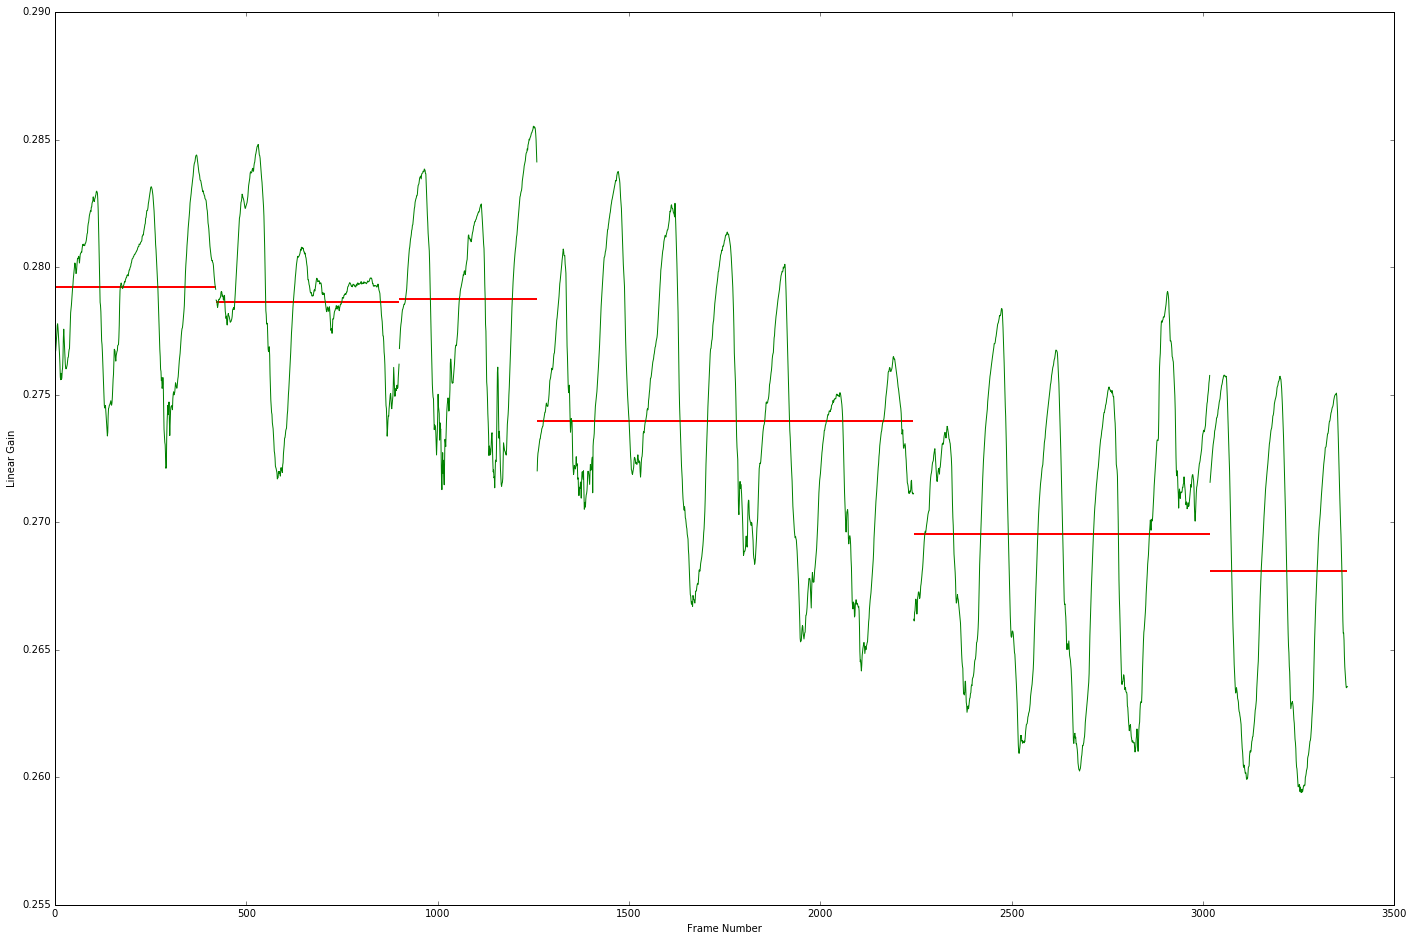

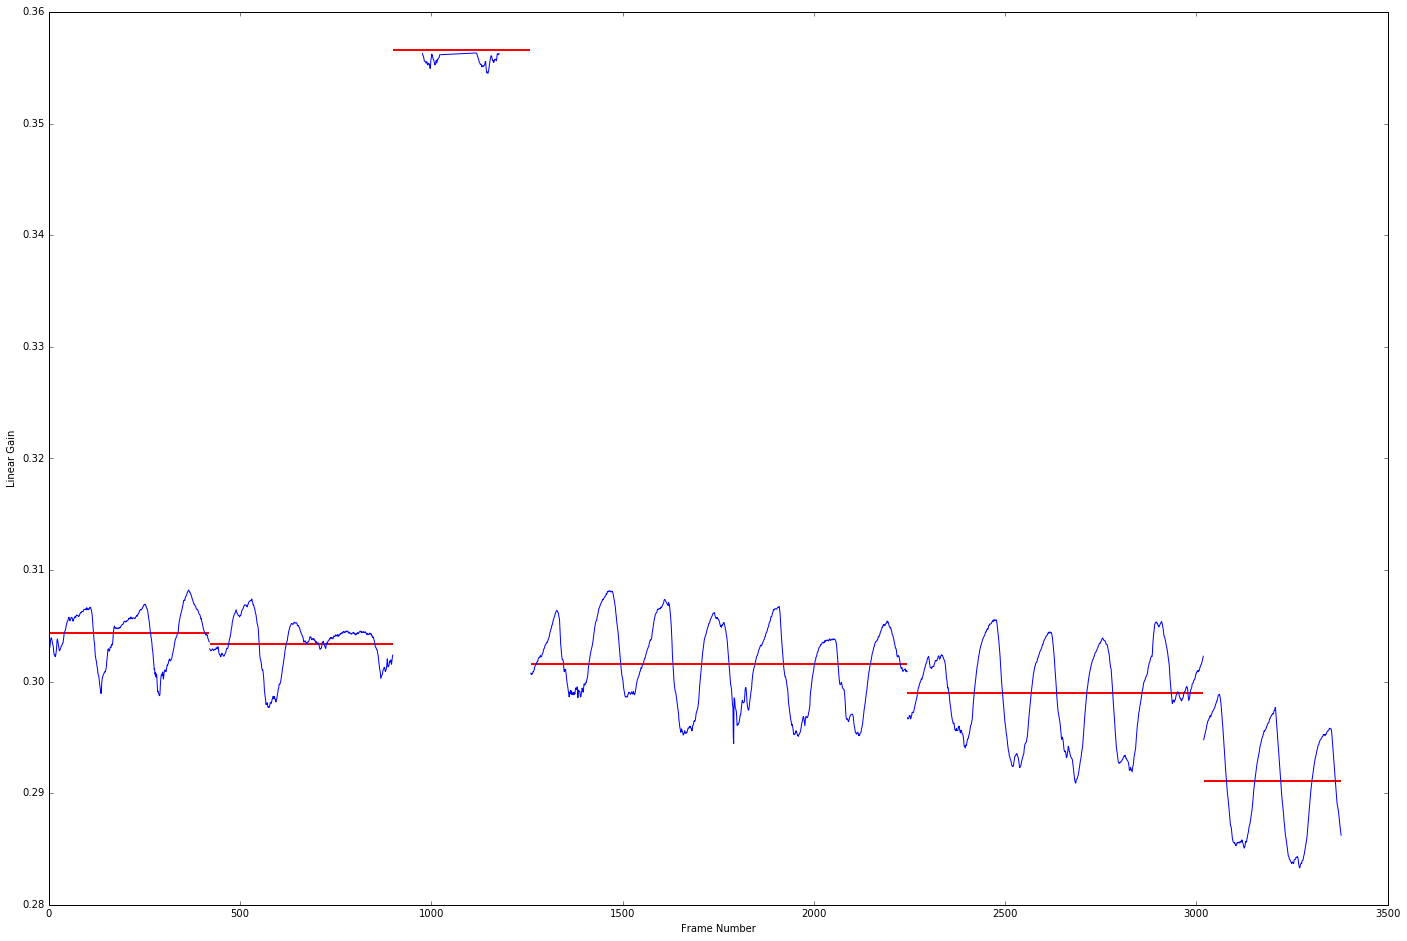

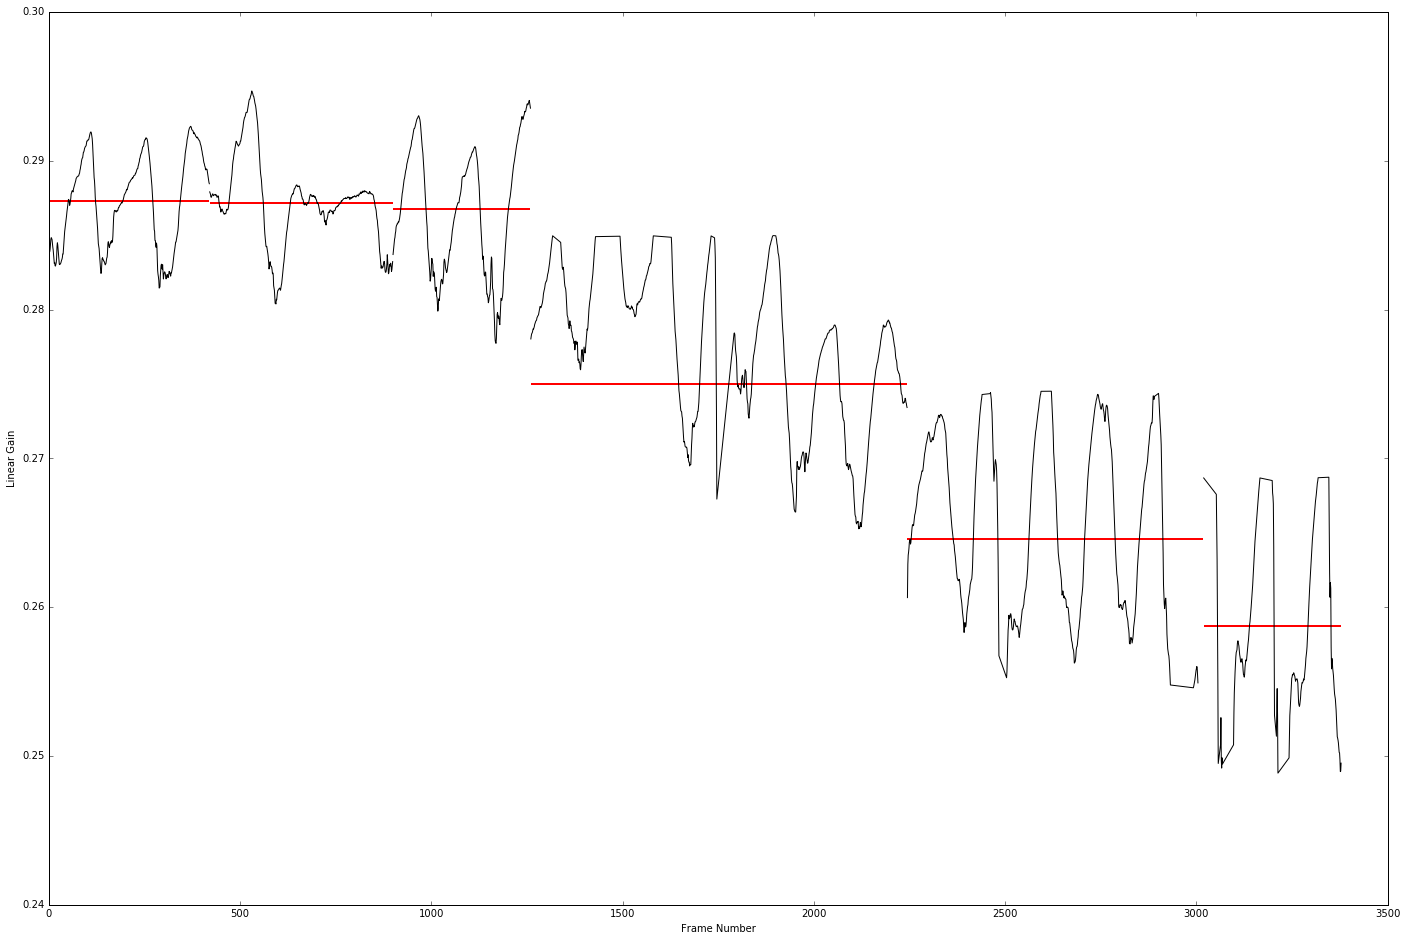

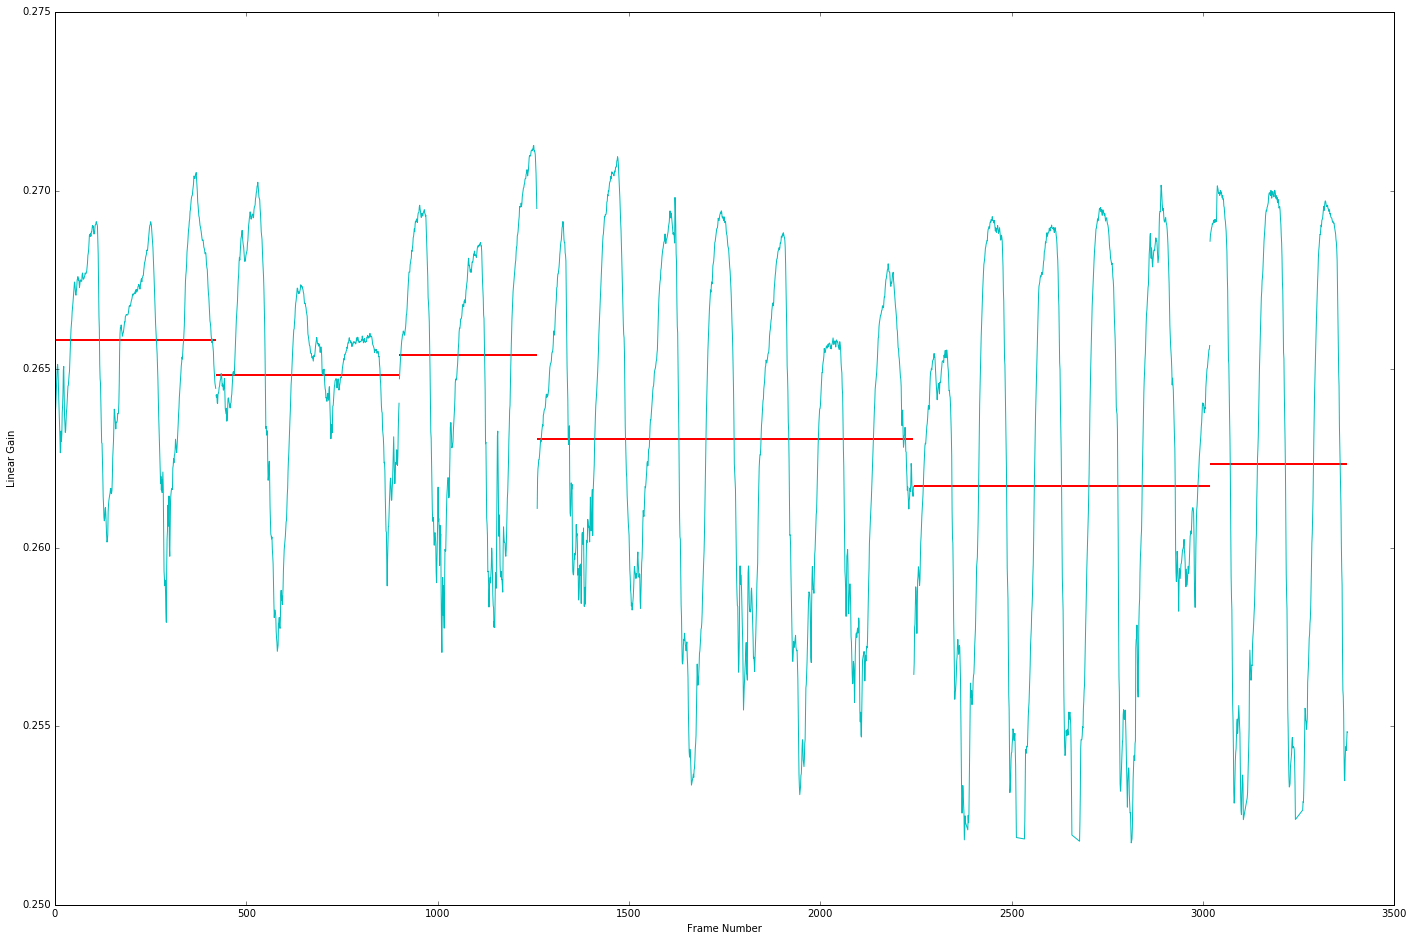

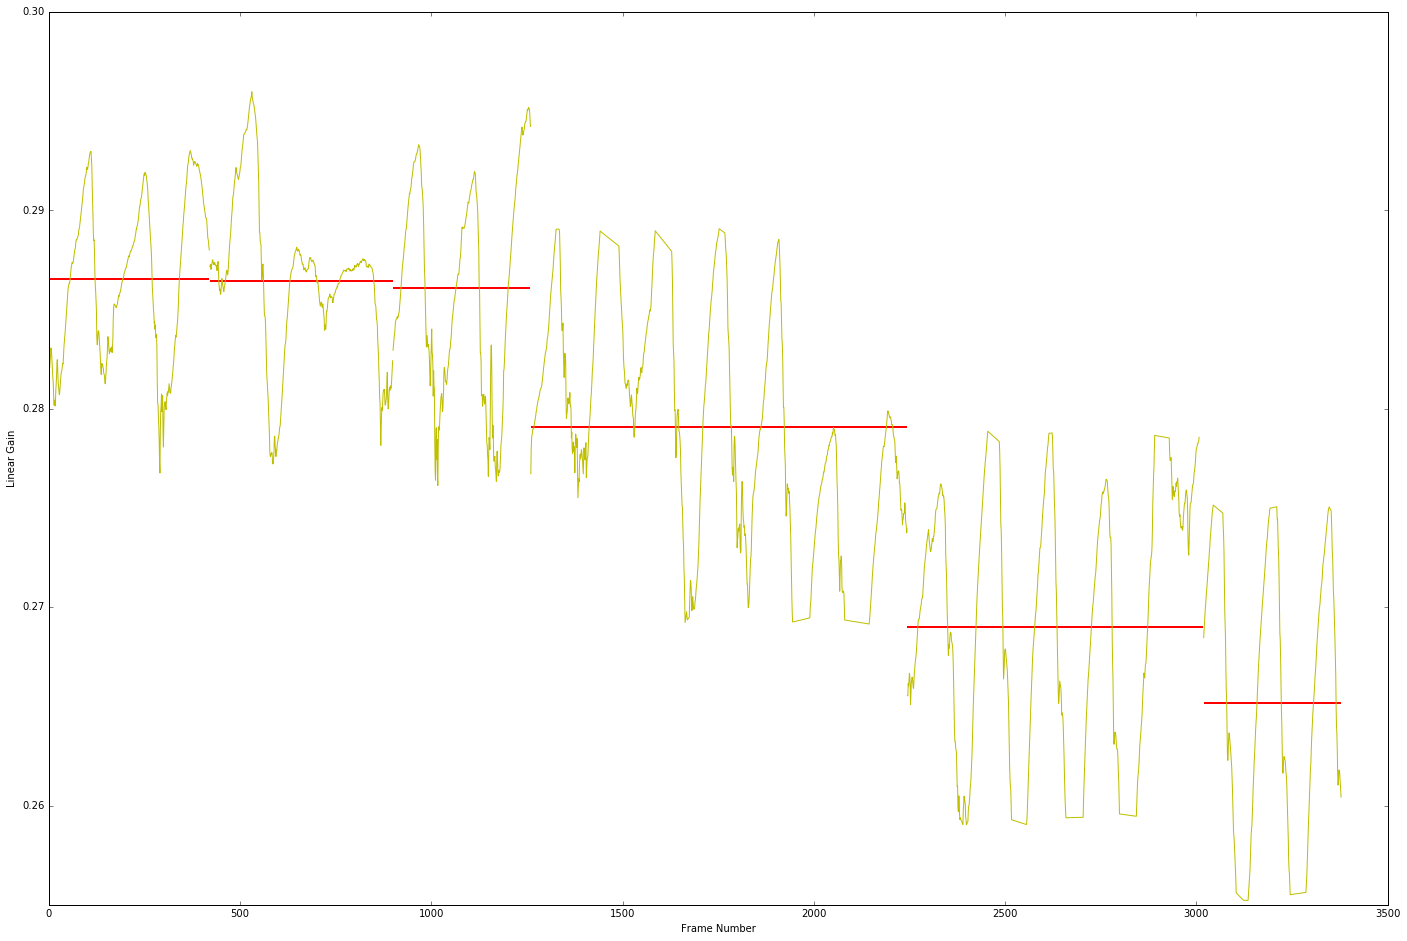

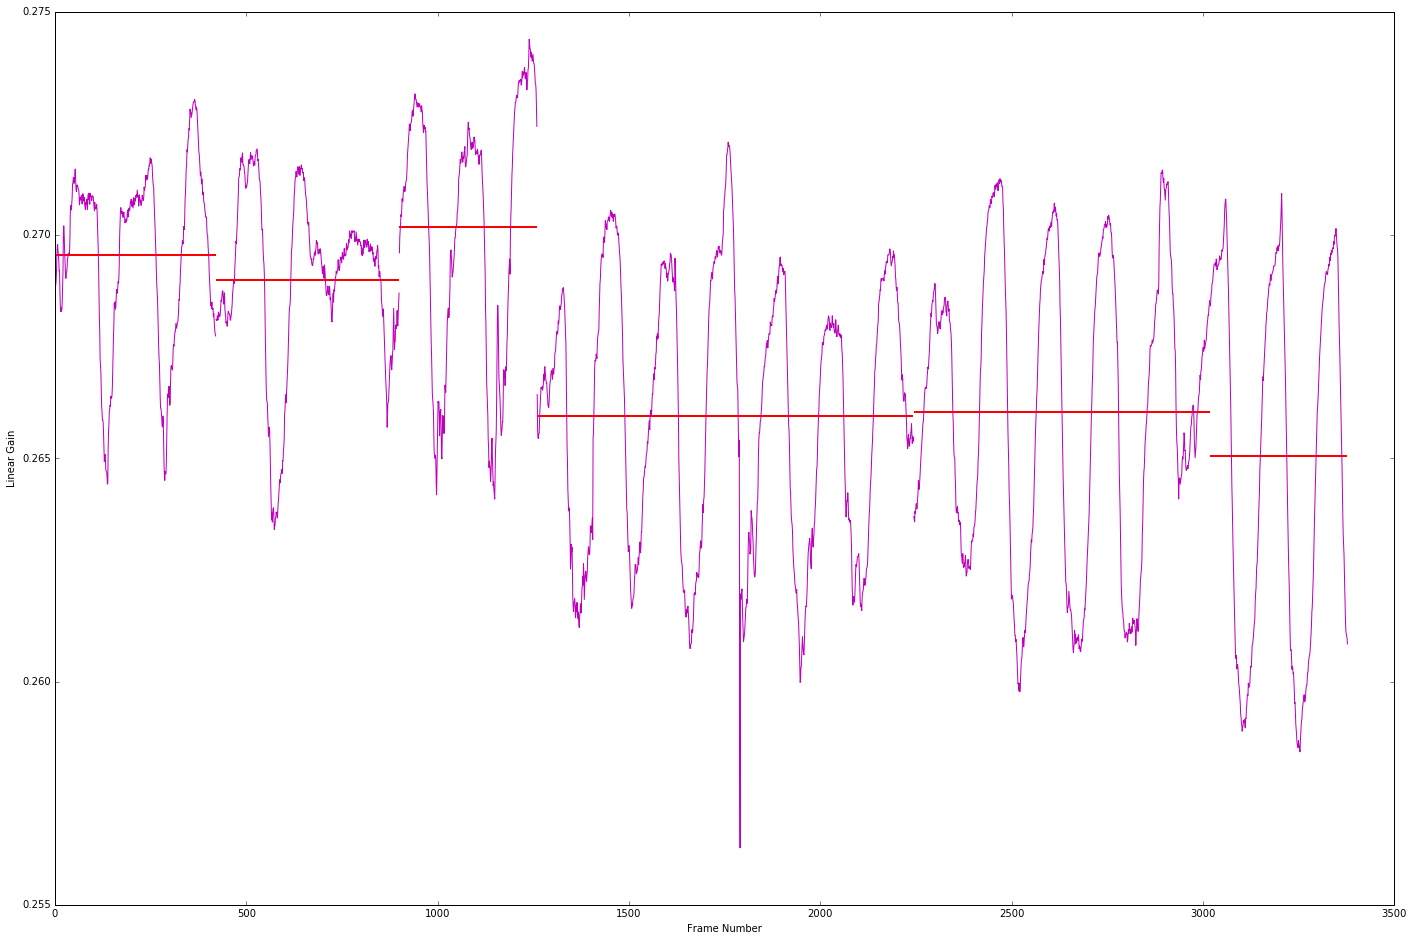

In [301]:
count_date=0
frame = np.linspace(0, len(gain_all[:,1,freq]), num=len(gain_all[:,1,freq]))
frame_per_dir = [421,479,360,984,774,360]
frame_seperate=[360,61,360,119,360,360,360,264,360,360,54,360]
date_time_all = []
for i in range(len(corr_list)):
    frame_count = 0
    for x in range(len(frame_per_dir)):
        time_stamp_sel= []
        time_stamp_temp = []
        m = ((gain_all[frame_count:frame_count+frame_per_dir[x],i,freq] < np.mean(gain_all[frame_count:frame_count+frame_per_dir[x],i,freq]) + 0.01) & (gain_all[frame_count:frame_count+frame_per_dir[x],i,freq] > np.mean(gain_all[frame_count:frame_count+frame_per_dir[x],i,freq]) - 0.01) & (gain_all[frame_count:frame_count+frame_per_dir[x],i,freq] < np.mean(gain_all[:,i,freq])+0.05))
        plt.figure(i+1)
        #plt.plot(frame[m],gain_all[m,i,freq] ,'.' ,color = colors[k], label = str(legend_crosscorr[k]), markersize = 3)
        
        frame_sec = frame[frame_count:frame_count+frame_per_dir[x]]
        gain_sec = gain_all[frame_count:frame_count+frame_per_dir[x],i,freq]
        time_stamp_temp = time_stamp[frame_count:frame_count+frame_per_dir[x]]
        time_stamp_sel = time_stamp_temp#[m]
        date_time = [datetime.datetime.fromtimestamp(time)+ datetime.timedelta(hours=7) for time in time_stamp_sel]

        print (len(date_time))
        plt.plot(frame_sec[m],gain_sec[m],color = colors[i], markersize = 3)
        #plt.plot( gain_sec[m],color = colors[i], markersize = 3)
        plt.ylabel('Linear Gain')
        plt.xlabel('Frame Number')
        
        if i==0:
            date_time_all.append(date_time)
        
        plt.hlines(y=np.mean(gain_all[frame_count:frame_count+frame_per_dir[x],i,freq]), xmin=frame[frame_count], xmax=frame[frame_count+frame_per_dir[x]-1], color='red', zorder=1, linewidth=2)
        #plt.hlines(y=np.mean(gain_sec[m]), xmin=frame[frame_count], xmax=frame[frame_count+frame_per_dir[x]-1], color='red', zorder=1, linewidth=2)
        
        frame_count = frame_count+frame_per_dir[x]
    '''
    k=0
    count=0
    
    for k in range(len(frame_seperate)):
        plt.axvline(x=count, linewidth=2, color='k')
        count = count+frame_seperate[k]
    plt.axhline(y=np.mean(gain_all[:,i,freq]),linewidth=3)
    '''


# Finding Reflection Component for each cable

In [207]:
# returning gian_sub, reflection components index number, 
def reflection_comp(gain_part):
    components_all_cables=[]
    amplitude_all_cables=[]
    gain_all_line_sub=[]
    
    components=[]
    amplitude =[]
    
    z=np.polyfit(freq_phase[50:990], gain_part[0],1)
    p=np.poly1d(z)
    gain_line_sub = gain_part[0] - p(freq_phase[50:990])
    
    gain_all_line_sub.append(gain_line_sub)
    
    ifft_component = np.fft.ifft(gain_line_sub) 
    ifft_component1 = np.fft.ifft(gain_line_sub) 
    ifft_component0 = np.fft.ifft(gain_line_sub) 
    
    end = len(ifft_component)

    for i in range(end):
        if np.abs(ifft_component[i]) > np.mean(np.abs(ifft_component)):#-np.mean(np.abs(ifft_component))/2:
            components.append(i)
            amplitude.append(np.abs(ifft_component[i]))
    
    end_components = len(components)
    ifft_component1[components] = ifft_component1[33]

    for i in range(len(ifft_component)):
        if i  not in components: 
            ifft_component0[i] = 0
    return components, gain_line_sub , p(freq_phase[50:990])
      

In [208]:
def my_sin(term2,amp,phase,n):
    return amp*np.sin(n*term2 + phase)

In [209]:
# "K" is varying cable, "X" is varying frames in directory, "I" for components for those frames, "KK" for 

reflection_components = []
parameters_all_cables = []
parameters_part_all_cables = []
reflections_generate_all_cable=[]
gain_generate_all_cables = []
lin_line_all_cables =[]
raw_gain_all_cables = []
frame = np.linspace(0, len(gain_all[:,1,freq]), num=len(gain_all[:,1,freq]))

N= len(freq_phase[50:990])
term2 = np.arange(N) 

for ii in range(len(corr_list)):
    reflection_components.append([])
    parameters_all_cables.append([])
    reflections_generate_all_cable.append([])
    gain_generate_all_cables.append([])
    lin_line_all_cables.append([])
    raw_gain_all_cables.append([])
    
for k in range(len(corr_list)):
    frame_count = 0
    reflections_generate_one_cable = []
    gain_generate_one_cable = []
    lin_line_one_cable = []
    raw_gain_one_cable = []
    
    #for ii in range(len(frame_per_dir)):
    #    parameters_part_all_cables.append([])
    
    for x in range(len(frame_per_dir)):
        time_stamp_sel= []
        time_stamp_temp = []
        ref_terms=[]
        ifft_reflection_part = []
        ifft_reflections_real = []
        reflections_generate_part_one_cable = np.zeros(len(gain_all[0,1,:]))
        
        frame_sec = frame[frame_count:frame_count+frame_per_dir[x]]
        gain_sec = gain_all[frame_count:frame_count+frame_per_dir[x],k,:] 
        
        time_stamp_temp = time_stamp[frame_count:frame_count+frame_per_dir[x]]
        date_time = [datetime.datetime.fromtimestamp(time) for time in time_stamp_sel]

        ref_terms, gain_sub_part, lin_line_part = reflection_comp(gain_sec)
        reflection_components[k].append(ref_terms)
        
        parameters = np.zeros(shape=(np.int(len(reflection_components[k][x])),3))
        
        for i in range(np.int(len(reflection_components[k][x]))):
            ifft_reflection_part = np.fft.ifft(gain_sub_part)

            for kk in range(len(ifft_reflection_part)):
                if kk != reflection_components[k][x][i]:
                    ifft_reflection_part[kk]=0

            ifft_reflections_real = np.real(np.fft.fft(ifft_reflection_part))

            guess_amplitude = np.max(ifft_reflections_real)
            guess_phase = 0.75 #1.5 
            n=2*np.pi*reflection_components[k][x][i]/940

            if i==2:
                guess_phase = 1.5
            if i==9:
                guess_phase = np.pi

            guess_offset = np.mean(ifft_reflections_real) 
            p0=[ guess_amplitude, guess_phase, n]

            fit = curve_fit(my_sin, term2, ifft_reflections_real, p0=p0)
            data_fit = my_sin(term2, *fit[0])

            fit_leastsq = leastsq(lambda p: my_sin(term2, *p) - ifft_reflections_real, p0)
            parameters[i,:]= fit[0]
            
            reflections_generate_part_one_cable = reflections_generate_part_one_cable + data_fit
        #parameters_part_all_cables[x].append(parameters)
        
        gain_generate_one_cable.append(gain_sub_part)
        raw_gain_one_cable.append(gain_sec)
        lin_line_one_cable.append(lin_line_part)
        frame_count = frame_count+frame_per_dir[x]
        reflections_generate_one_cable.append(reflections_generate_part_one_cable)
        
    reflections_generate_all_cable[k].append(reflections_generate_one_cable)
    gain_generate_all_cables[k].append(gain_generate_one_cable)
    lin_line_all_cables[k].append(lin_line_one_cable)
    raw_gain_all_cables[k].append(raw_gain_one_cable)
    #parameters_all_cables[k].append(parameters_part_all_cables)

In [144]:
#gain_generate_all_cables
#reflection_generate_all_cables

2017-04-10 11:27:58


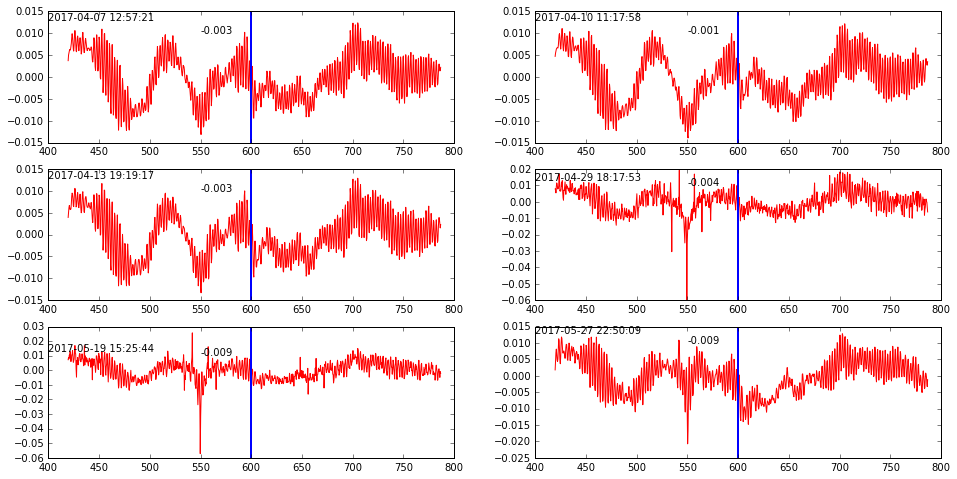

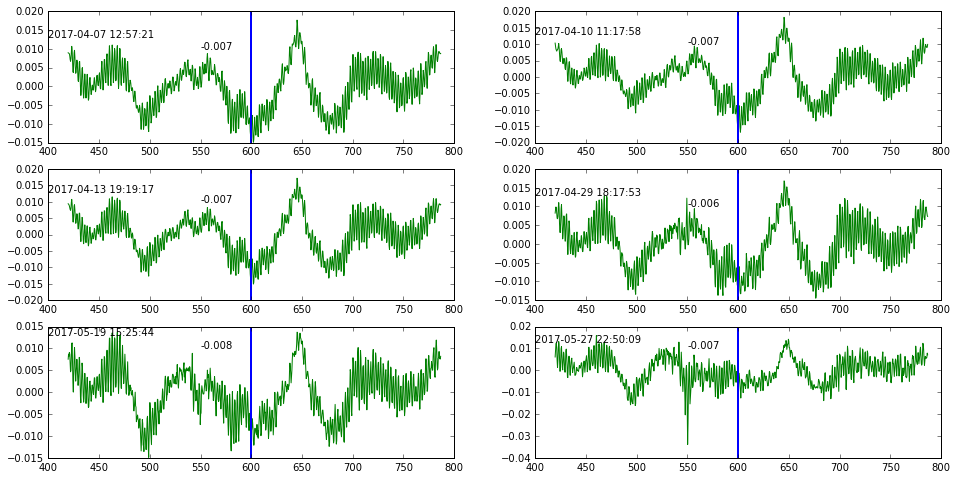

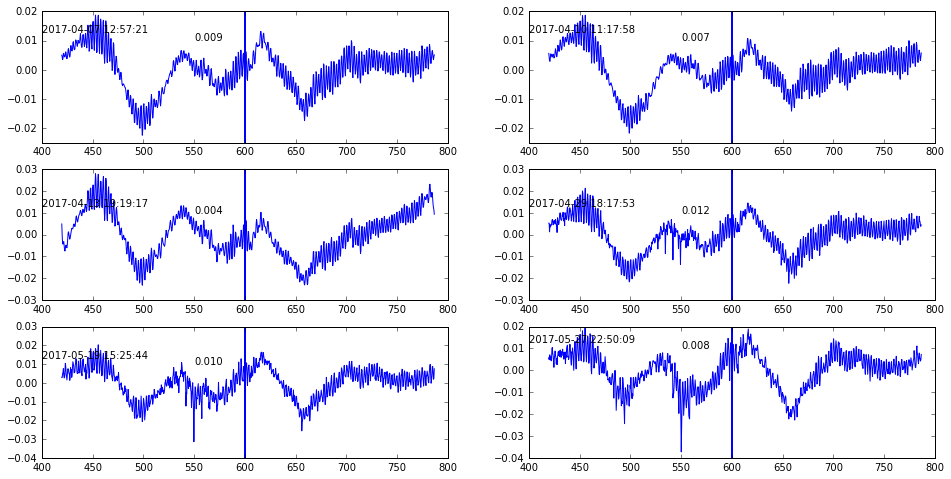

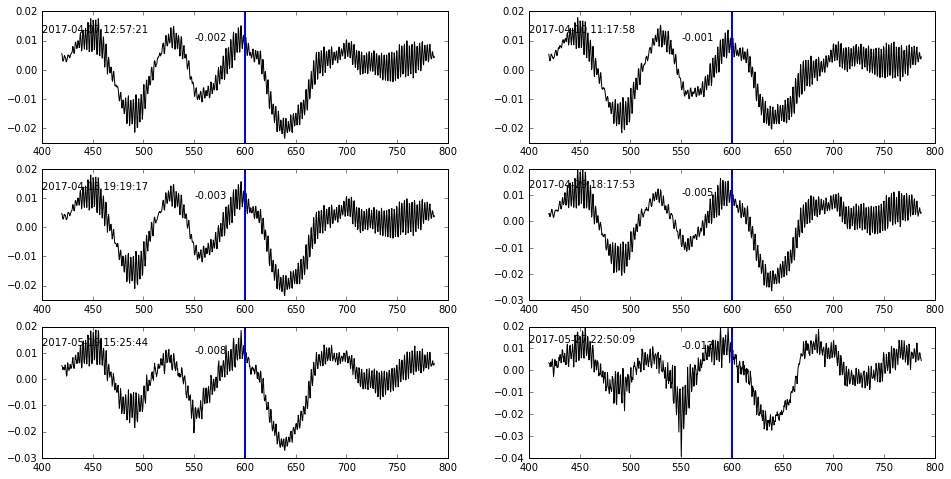

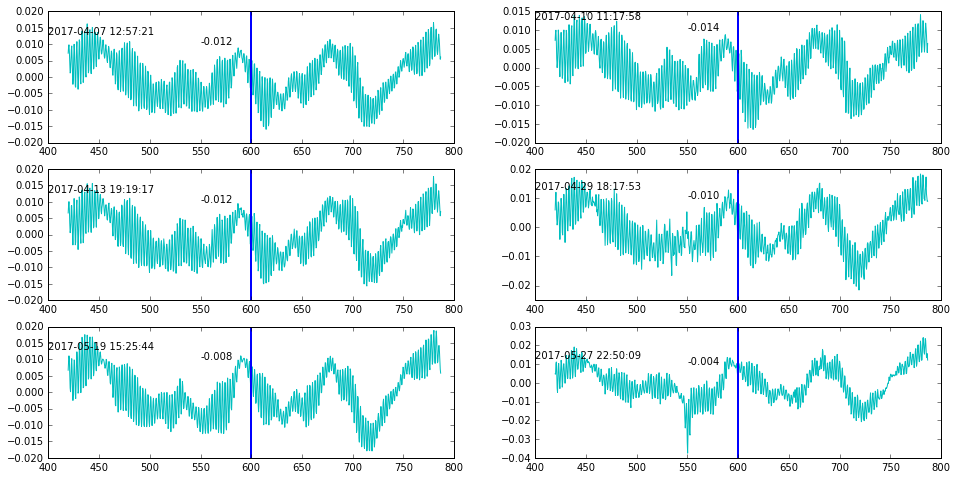

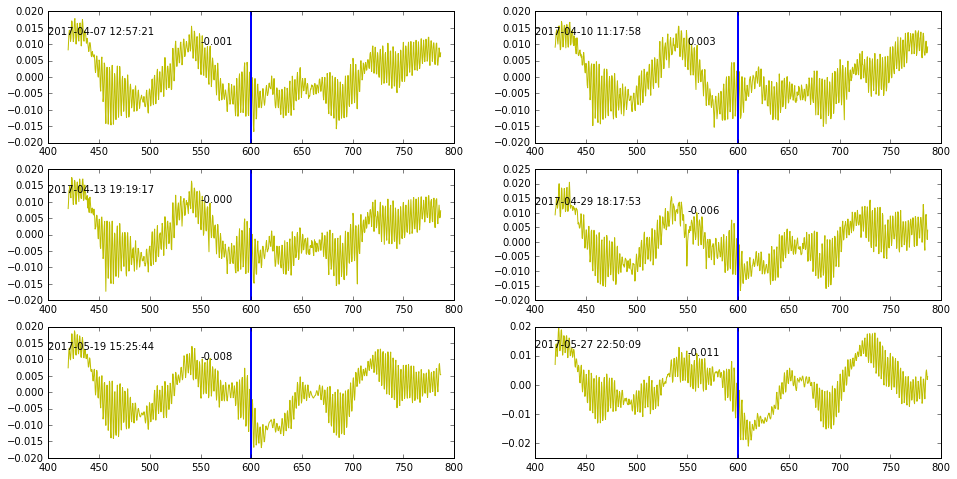

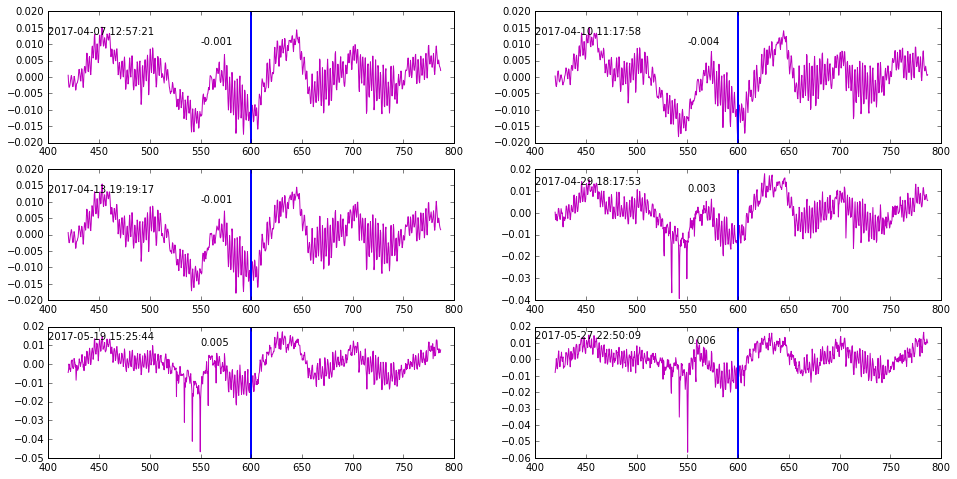

In [210]:

for i in range(len(reflections_generate_all_cable)):
    
    plt.figure(i+1)
    plt.title('Reflections for cable %i' %(i+1))
    for k in range(len(reflections_generate_all_cable[i][0])):
        
        plt.subplot(3,2,k+1)
        plt.plot(freq_phase[50:990],reflections_generate_all_cable[i][0][k], color = colors[i])
        
        plt.text(400, 0.013, str(date_time_all[k][0]))
        plt.text(550, 0.010, str('%.3f' %reflections_generate_all_cable[i][0][k][freq]))
        #plt.text(400, 0, str('%.3f' %np.mean(reflections_generate_all_cable[i][0][k])))
        
        #plt.axhline(y=np.mean(reflections_generate_all_cable[i][0][k]), linewidth = 1)
        plt.axvline(x=600, linewidth=2)
#print (reflections_generate_all_cable[2][0][1])



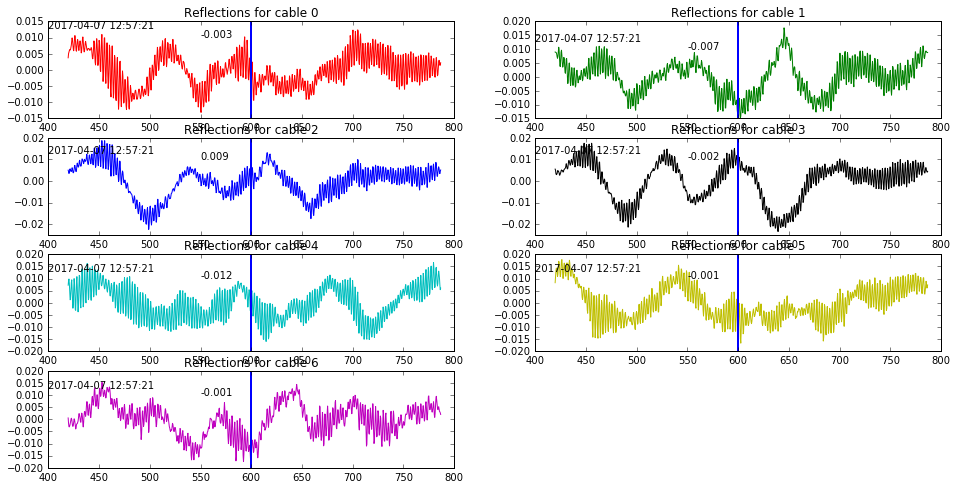

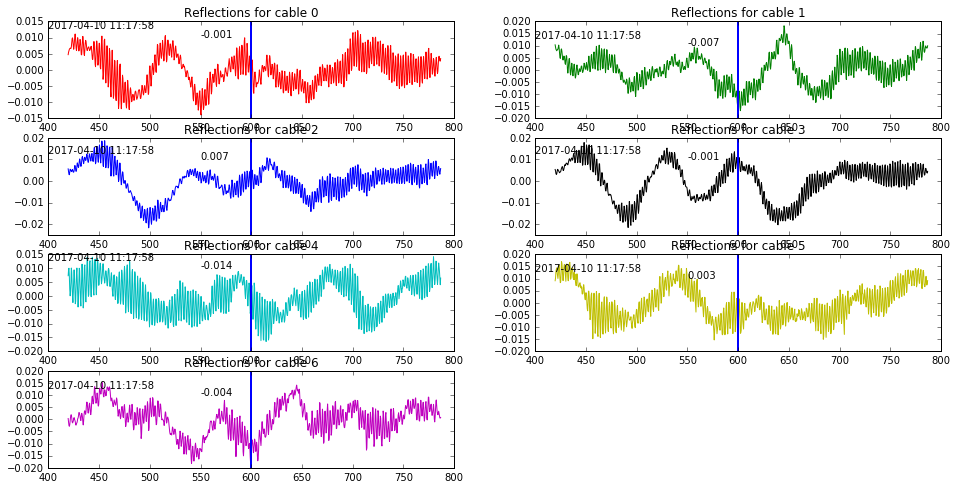

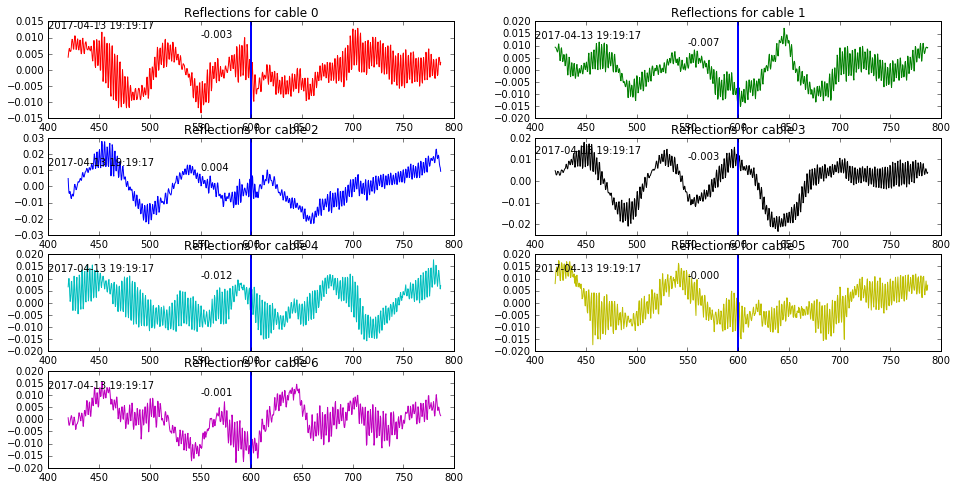

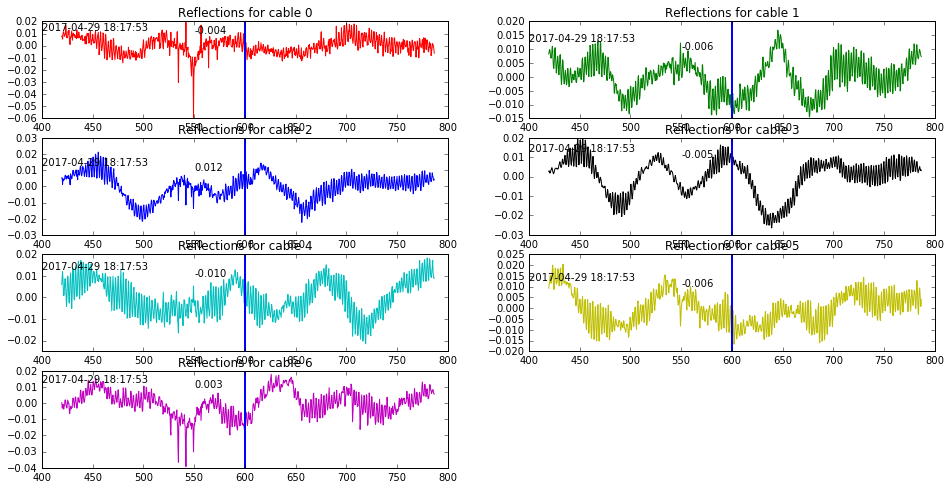

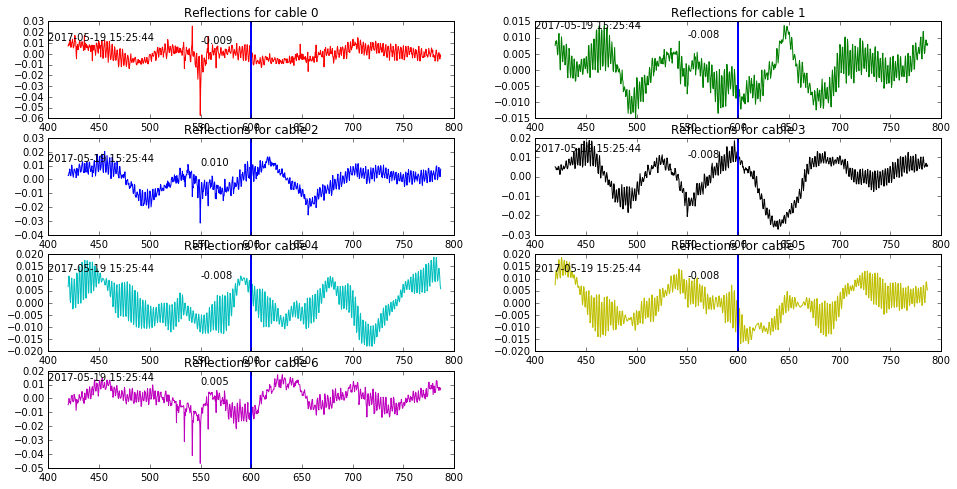

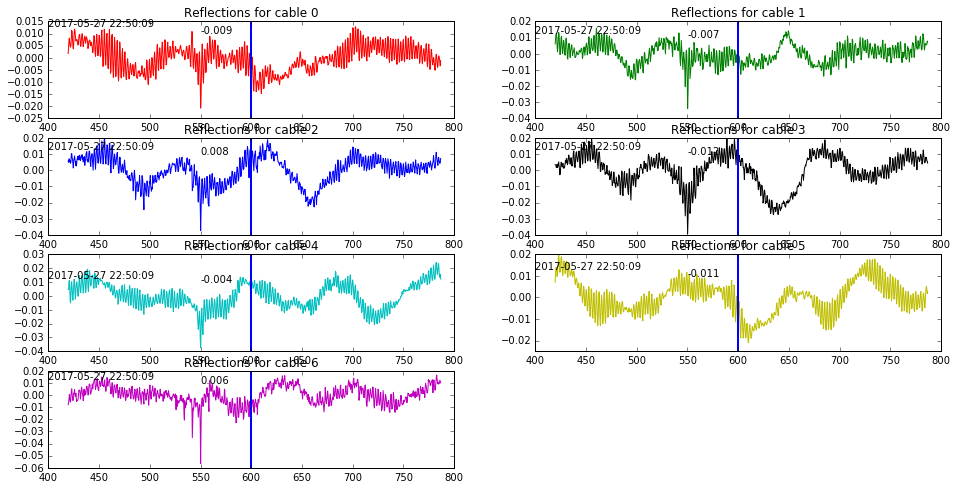

In [211]:

for i in range(len(reflections_generate_all_cable)):
    
    for k in range(len(reflections_generate_all_cable[i][0])):
        plt.figure(k+1)
        
        plt.subplot(4,2,i+1)
        plt.title('Reflections for cable %i' %(i))
        plt.plot(freq_phase[50:990],reflections_generate_all_cable[i][0][k], color = colors[i])
        
        plt.text(400, 0.013, str(date_time_all[k][0]))
        plt.text(550, 0.010, str('%.3f' %reflections_generate_all_cable[i][0][k][freq]))
        #plt.text(400, 0, str('%.3f' %np.mean(reflections_generate_all_cable[i][0][k])))
        
        #plt.axhline(y=np.mean(reflections_generate_all_cable[i][0][k]), linewidth = 1)
        plt.axvline(x=600, linewidth=2)

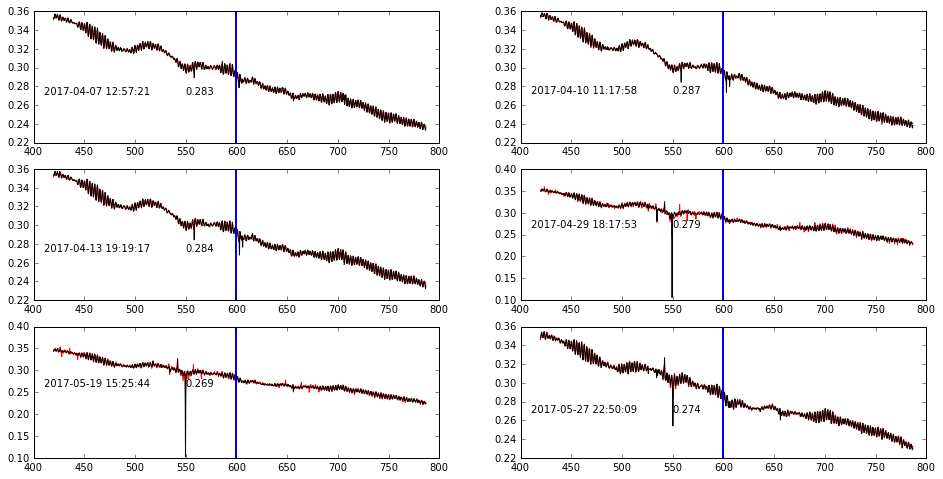

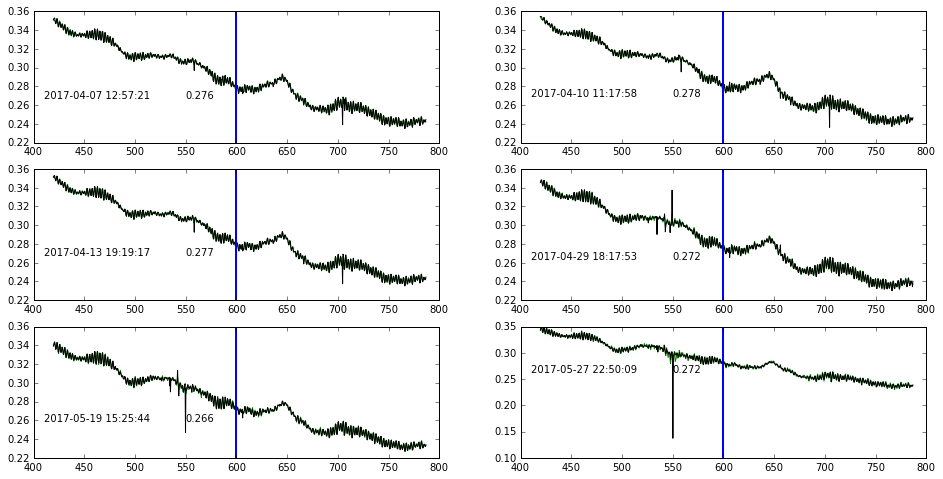

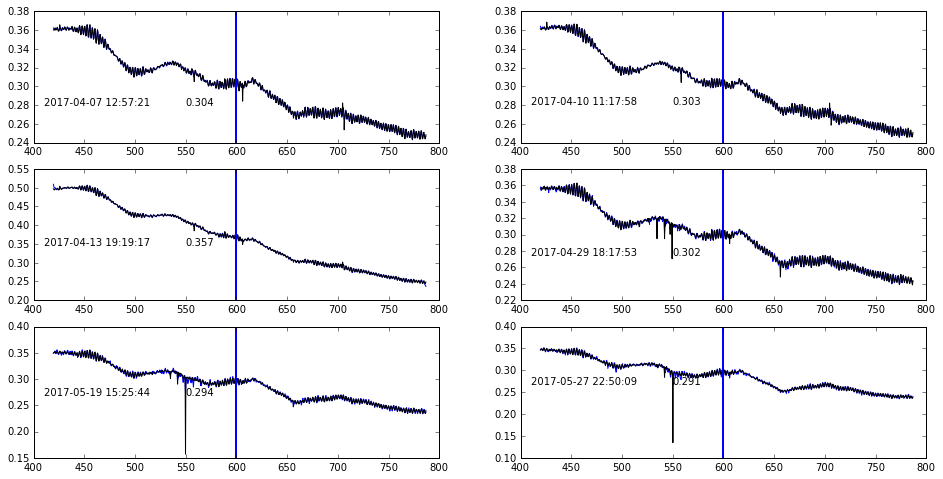

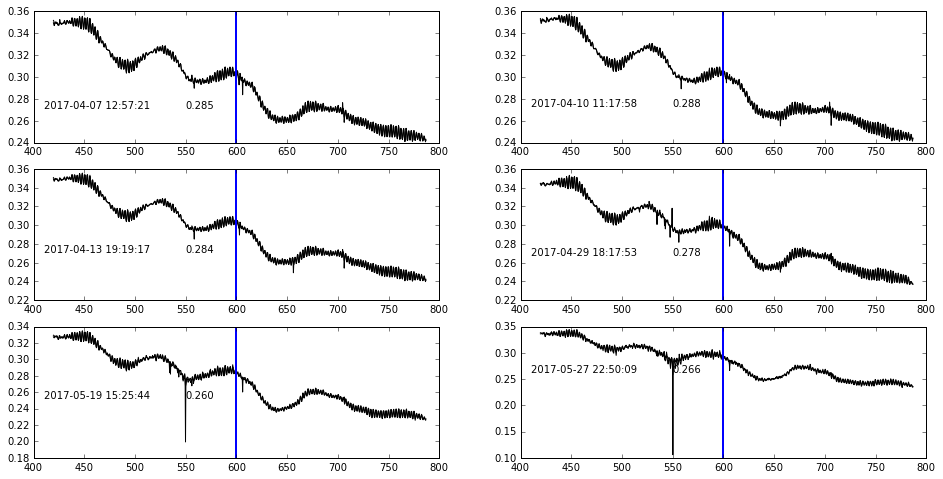

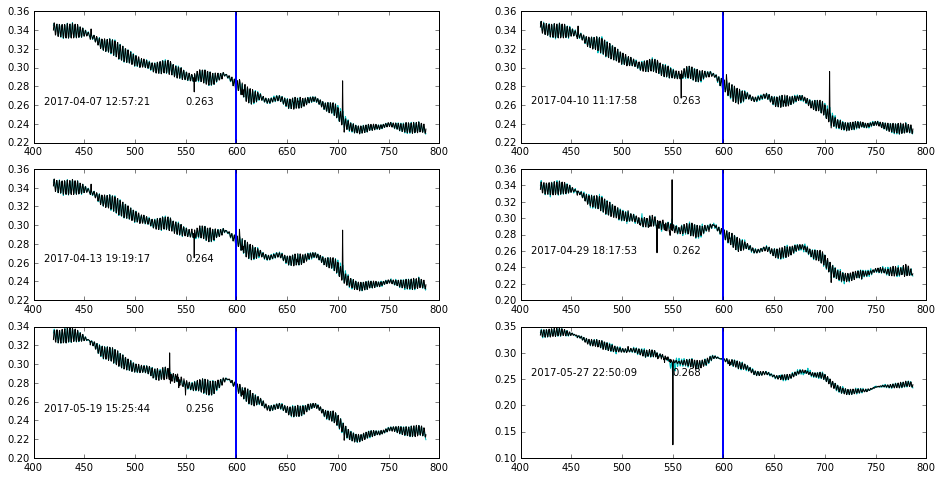

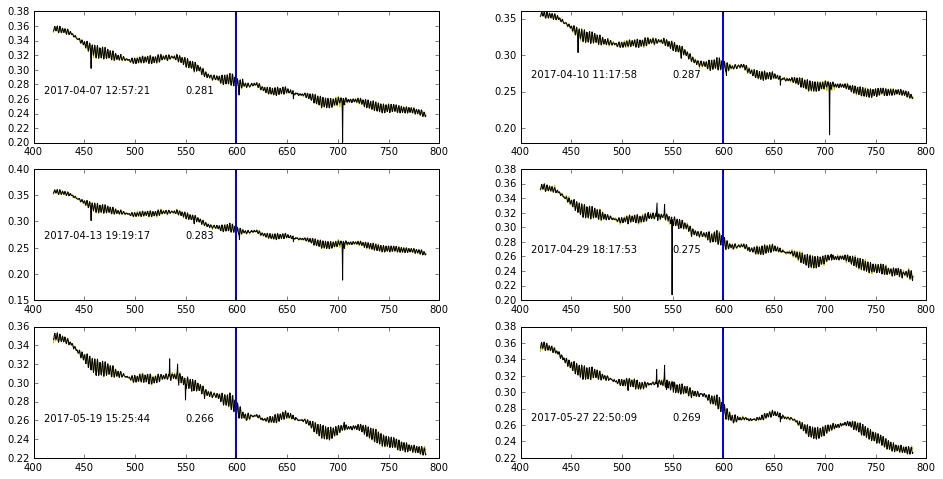

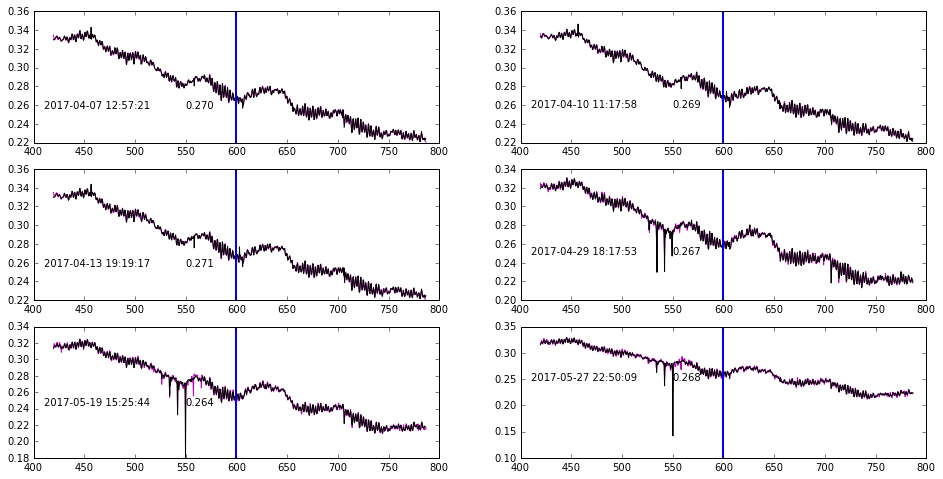

In [212]:
for i in range(len(reflections_generate_all_cable)):
    frame_count=0
    plt.figure(i+1)
    plt.title('Gain model %i' %(i+1))
    
    for k in range(len(reflections_generate_all_cable[i][0])):

        plt.subplot(3,2,k+1)
        plt.plot(freq_phase[50:990],reflections_generate_all_cable[i][0][k] + lin_line_all_cables[i][0][k], color = colors[i])
        plt.plot(freq_phase[50:990], gain_all[frame_count,i,:],'k' )
        plt.text(410, np.mean(reflections_generate_all_cable[i][0][k] + lin_line_all_cables[i][0][k])-0.02, str(date_time_all[k][0]))
        plt.text(550, np.mean(reflections_generate_all_cable[i][0][k] + lin_line_all_cables[i][0][k])-0.02, str('%.3f' %(reflections_generate_all_cable[i][0][k][freq]+lin_line_all_cables[i][0][k][freq] )))
        plt.axvline(x=600, linewidth=2)
        
        frame_count=frame_count + frame_per_dir[k]

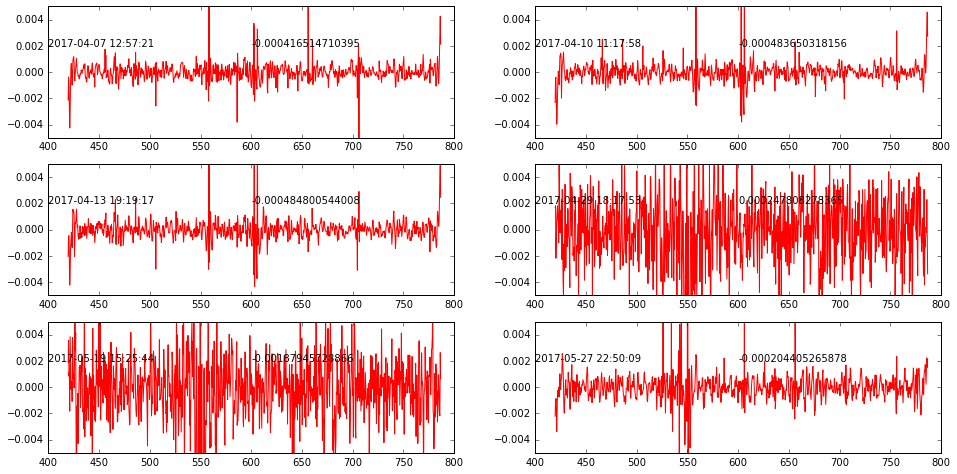

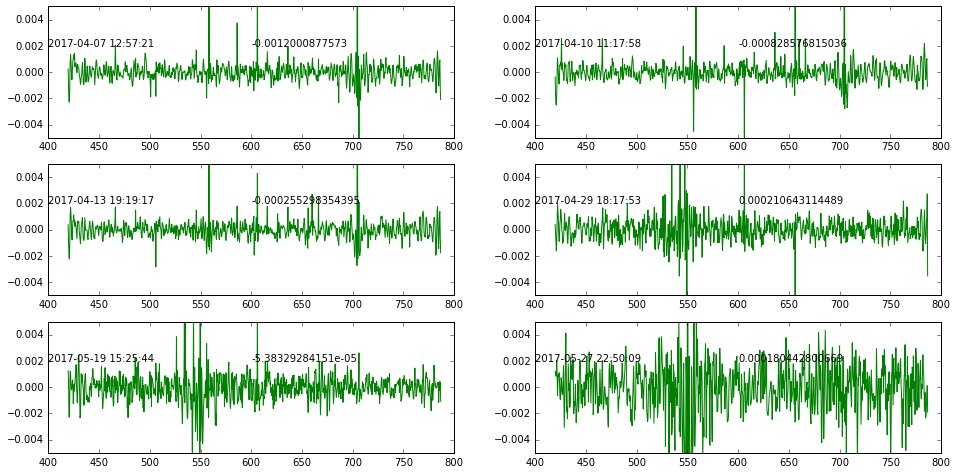

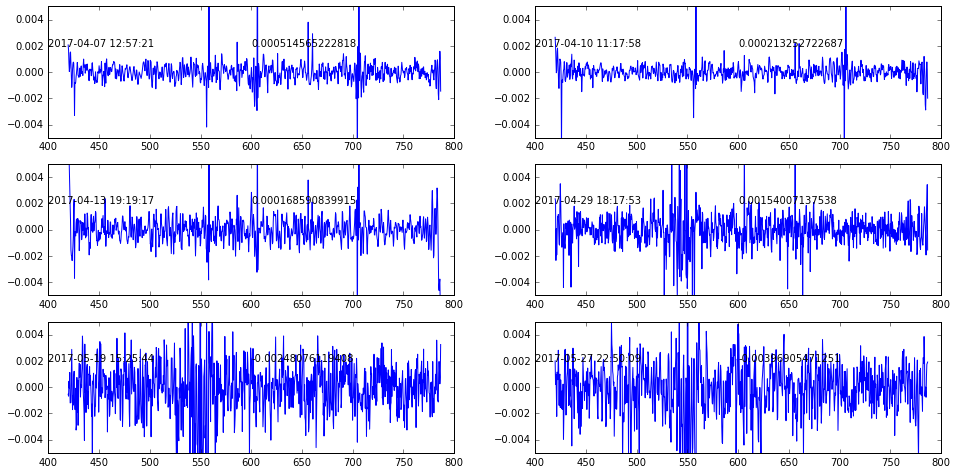

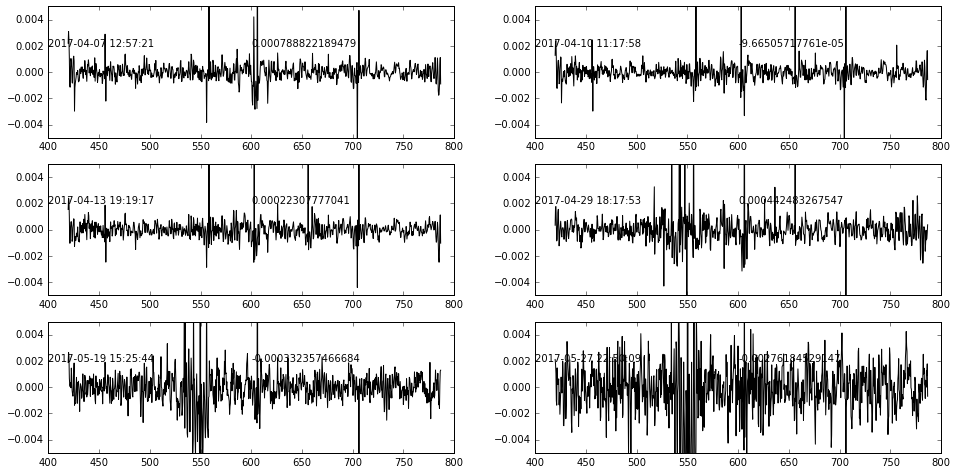

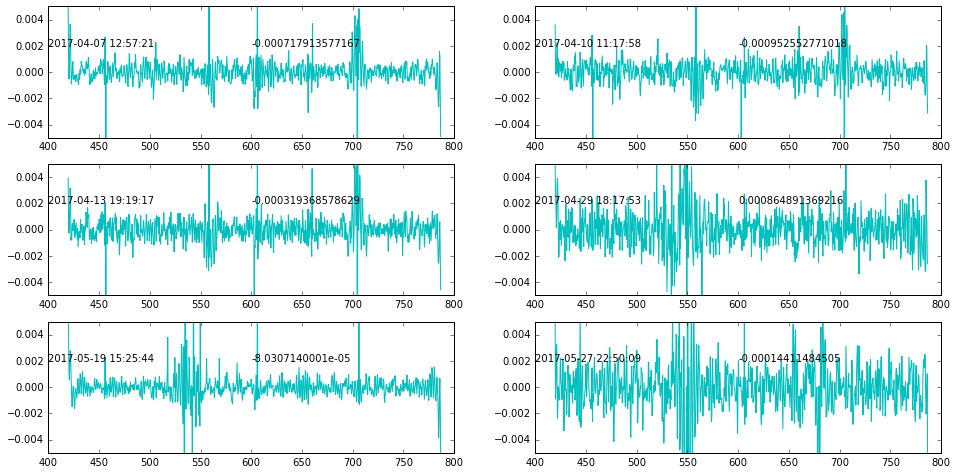

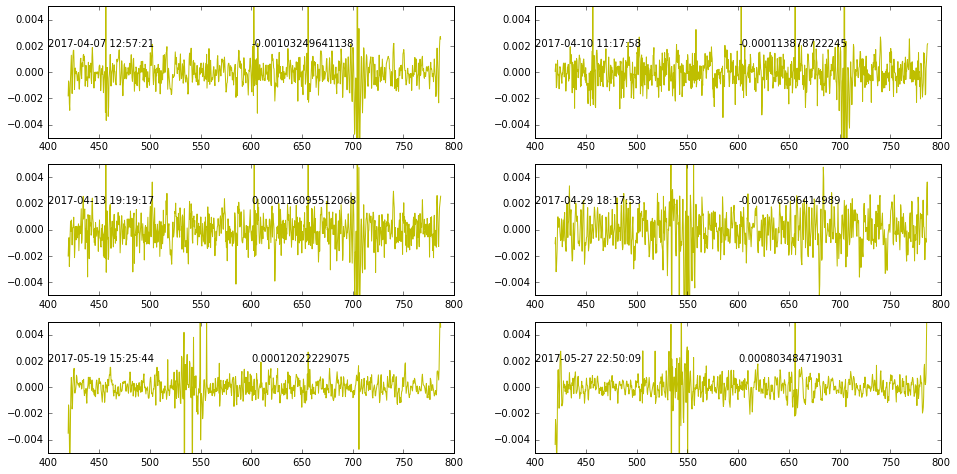

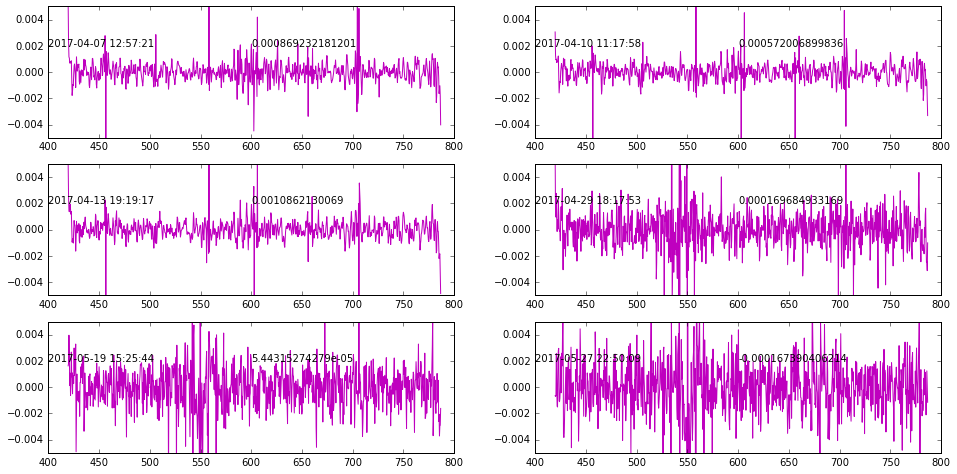

In [246]:
for i in range(len(reflections_generate_all_cable)):
    frame_count=0
    plt.figure(i+1)
    
    for k in range(len(reflections_generate_all_cable[i][0])):

        plt.subplot(3,2,k+1)
        plt.plot(freq_phase[50:990],reflections_generate_all_cable[i][0][k] + lin_line_all_cables[i][0][k] - gain_all[frame_count,i,:], color = colors[i])

        plt.ylim(-0.005,0.005)
        plt.text(400, 0.002, str(date_time_all[k][0]))
        plt.text(600, 0.002, str(reflections_generate_all_cable[i][0][k][freq] + lin_line_all_cables[i][0][k][freq] - gain_all[frame_count,i,freq]))
        frame_count=frame_count + frame_per_dir[k]

421
479
360
984
774
360


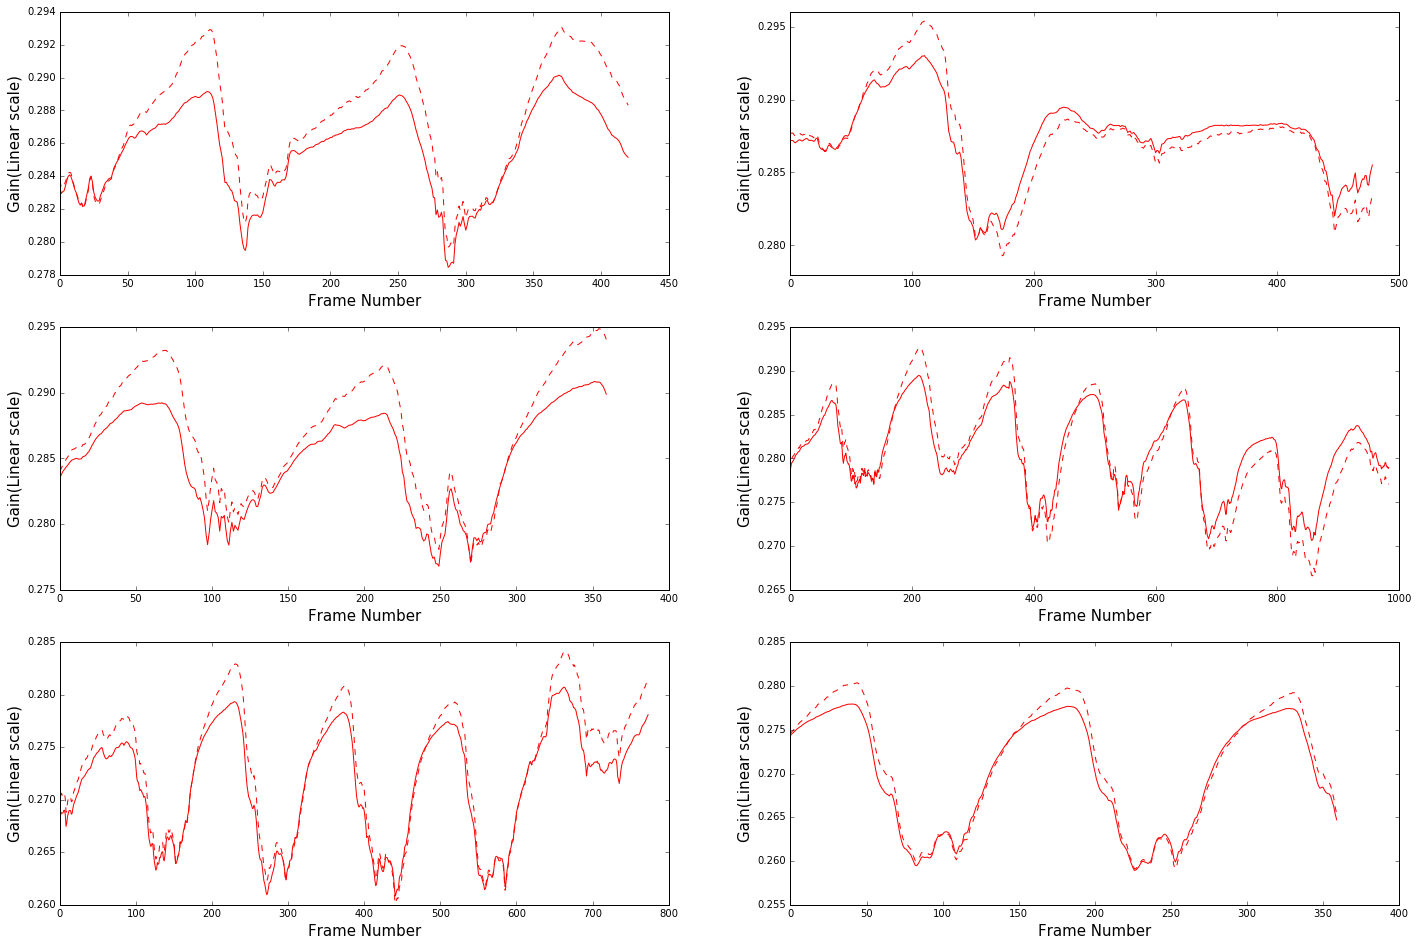

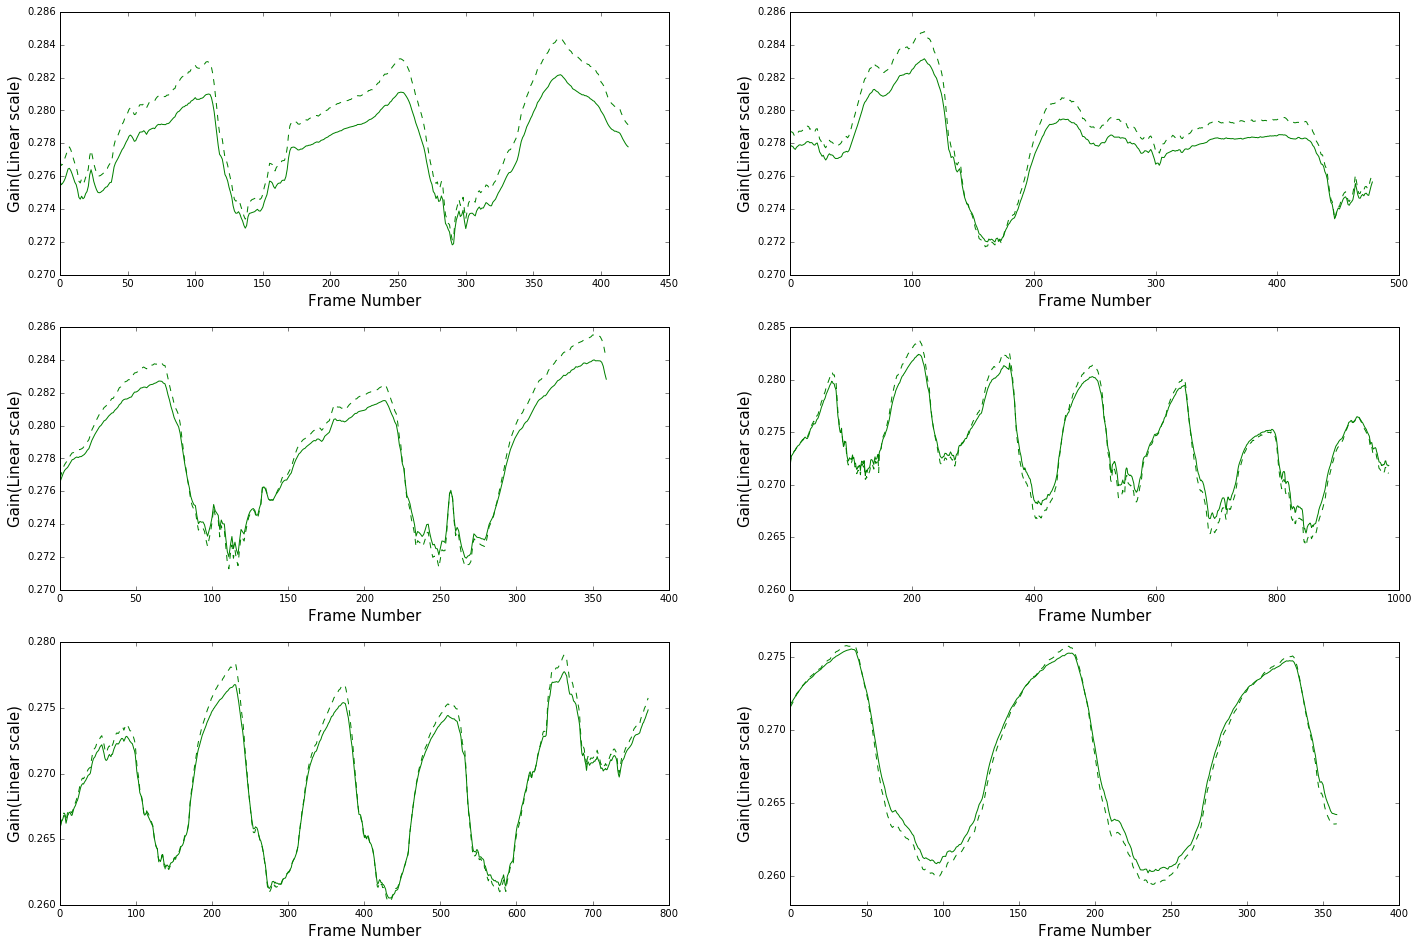

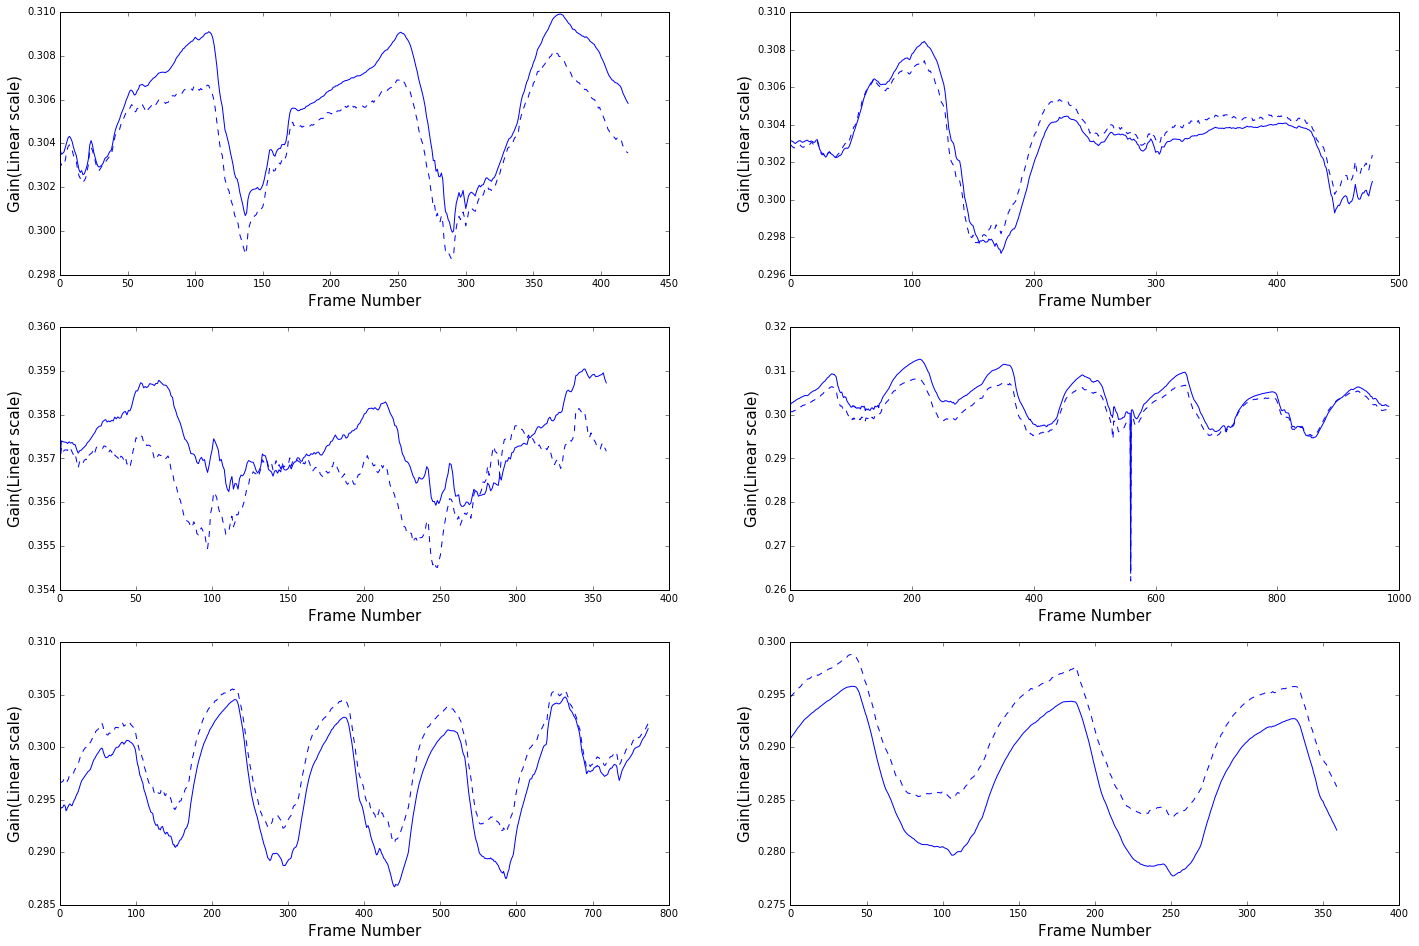

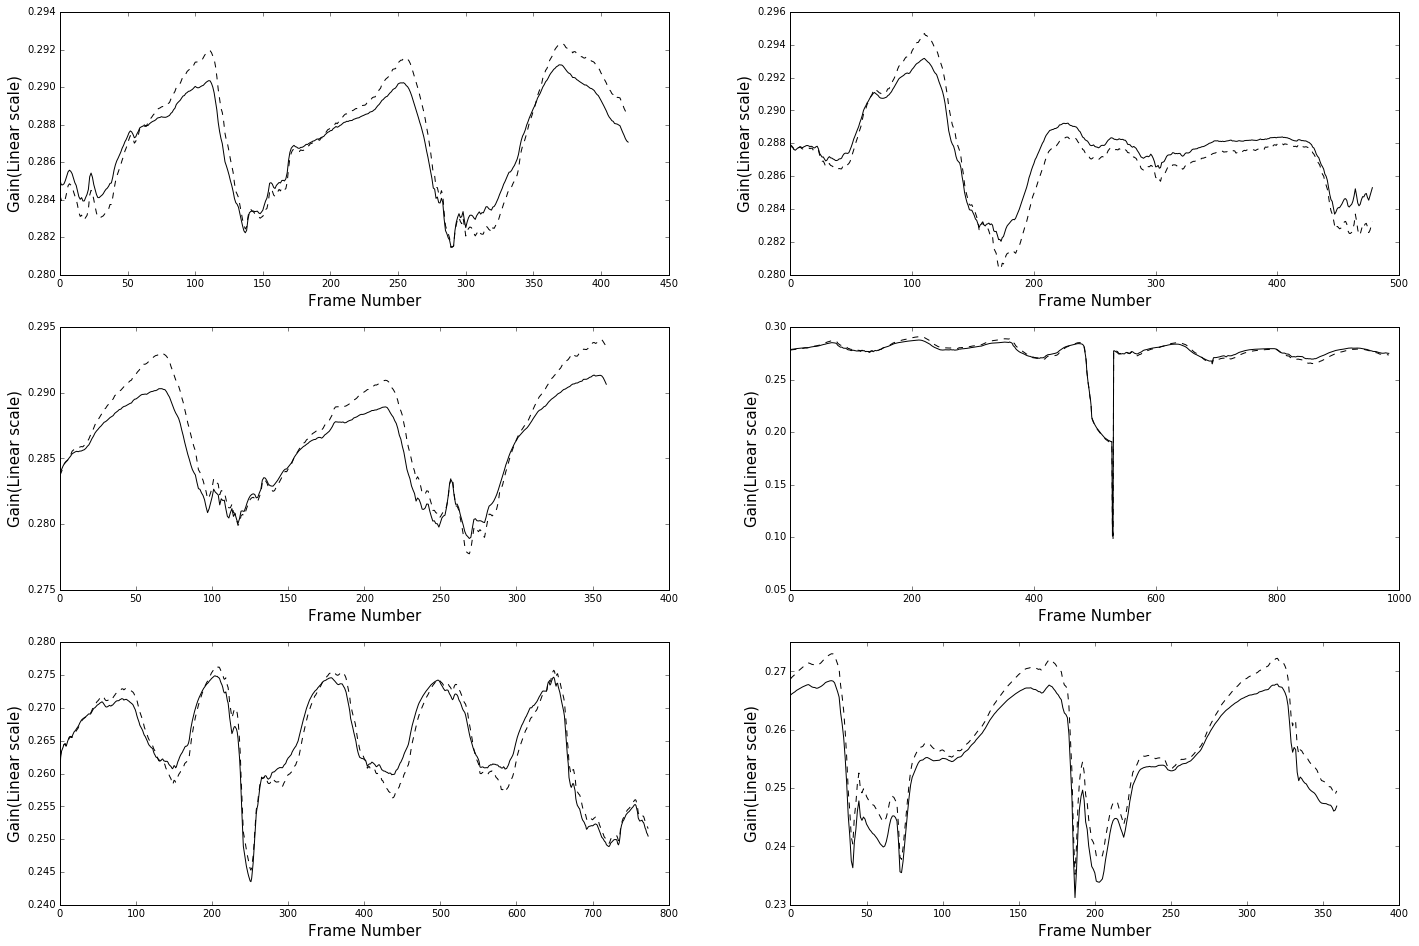

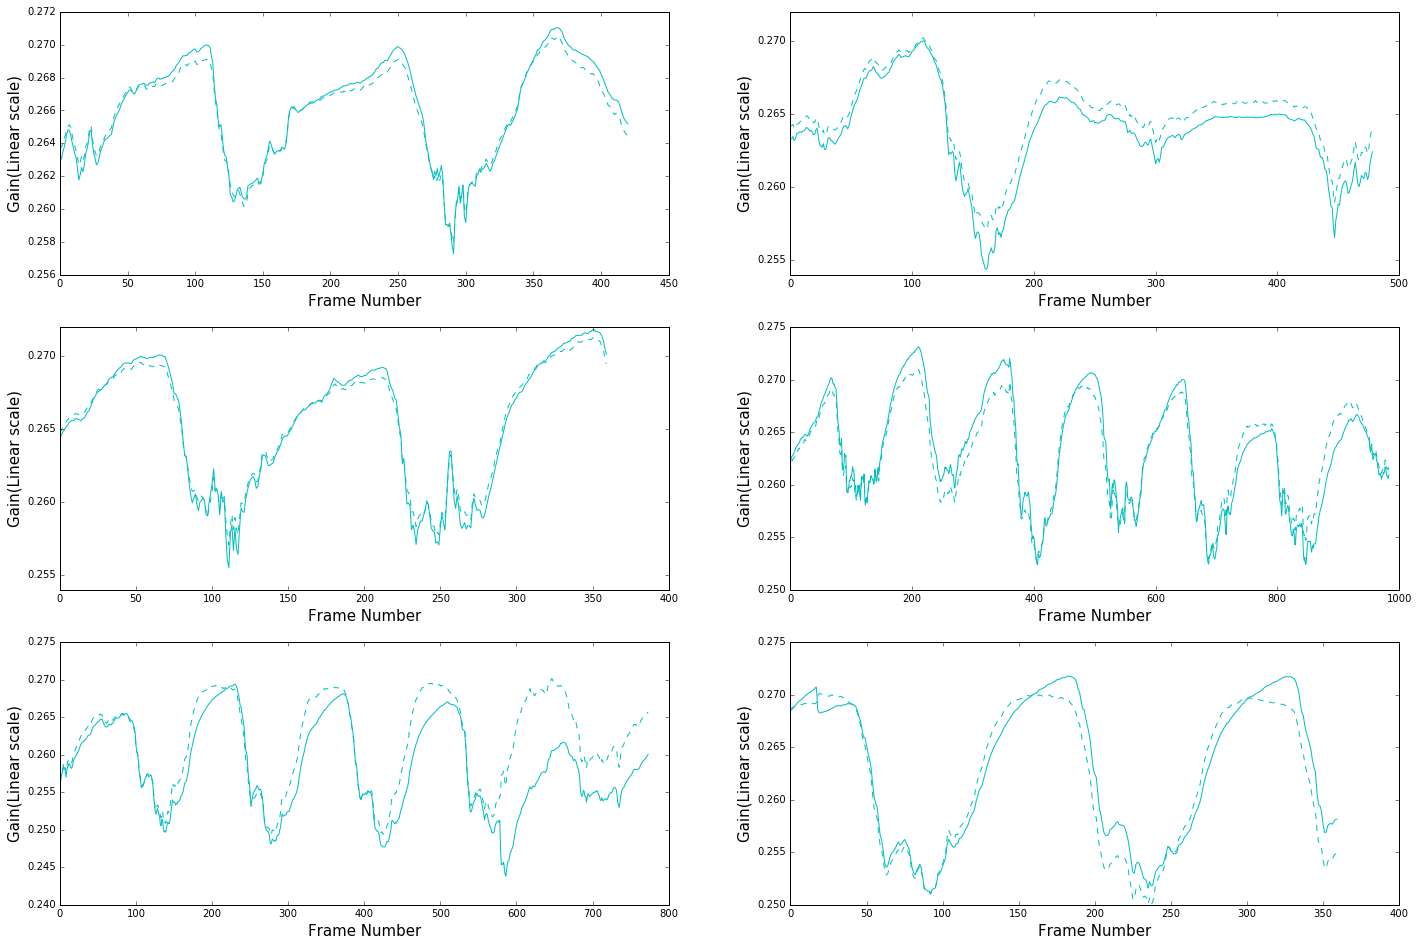

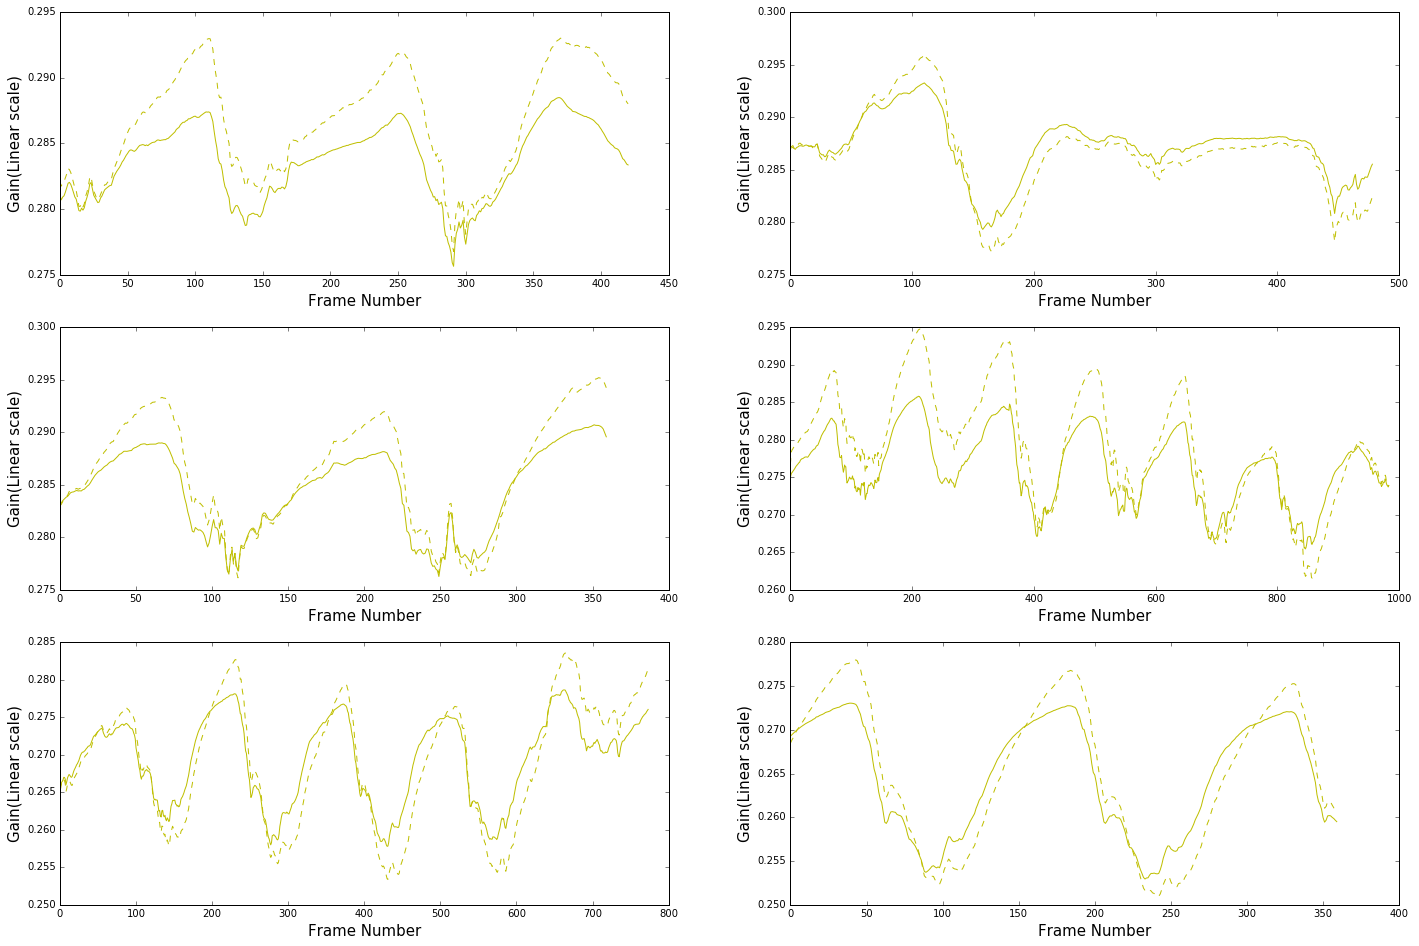

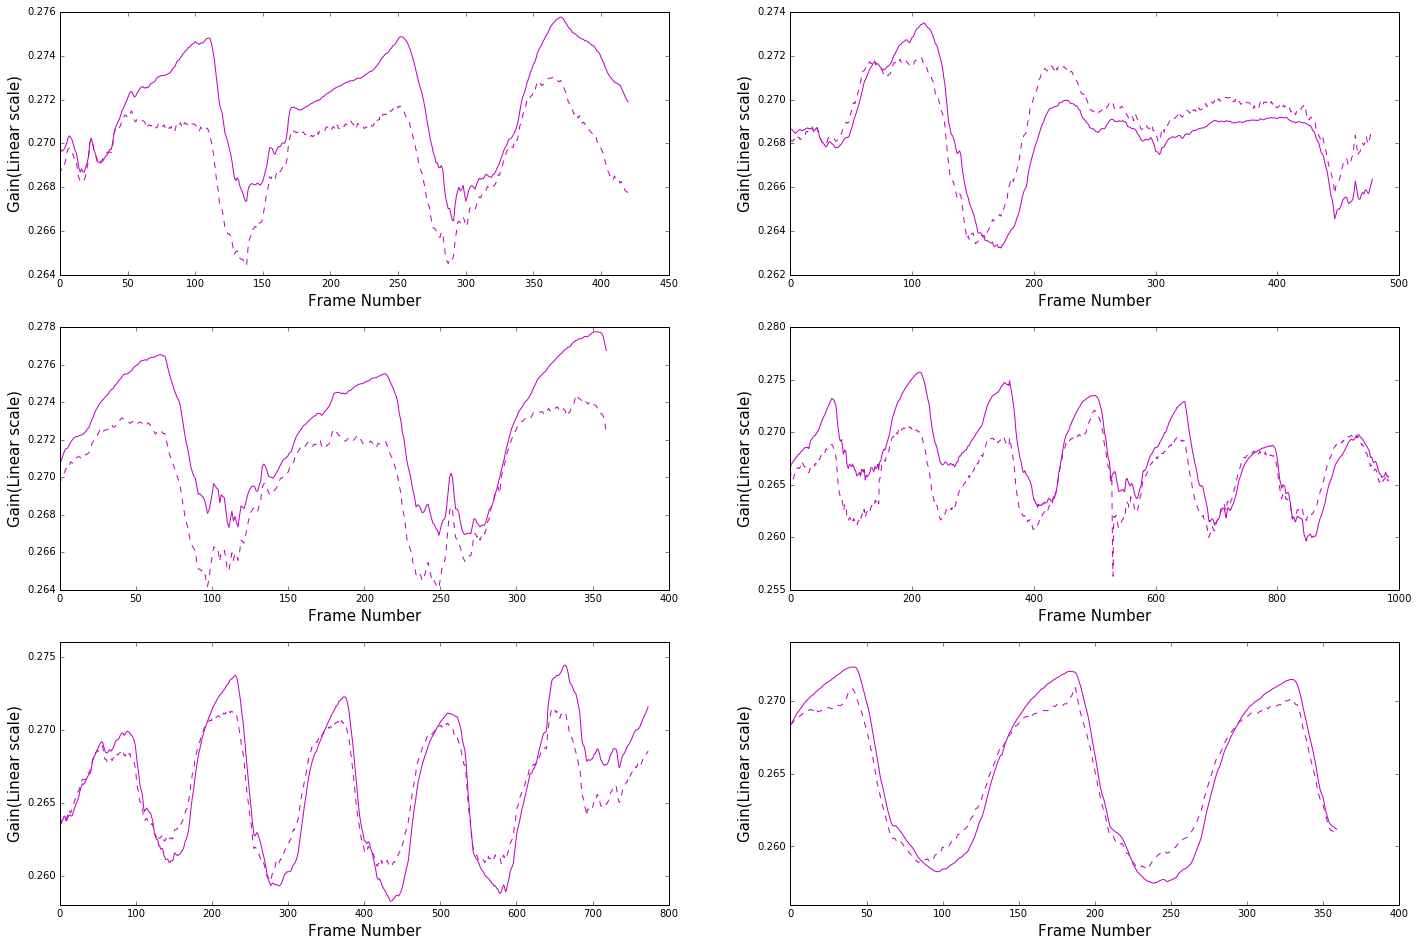

In [309]:
figure(figsize(24,16))
for i in range(len(reflections_generate_all_cable)):
    frame_count=0
    
    
    plt.figure(i+1)
    plt.title('çable number %i' %(i))
    frac_change_gain_per_cable_model = []
    frac_change_gain_per_cable_raw = []
    for k in range(len(reflections_generate_all_cable[i][0])):
        gain_per_frame_600 = np.zeros(frame_per_dir[k])
        gain_per_frame = np.zeros(frame_per_dir[k])
        
        for j in range(frame_per_dir[k]):
            z=np.polyfit(freq_phase[50:990], gain_all[frame_count+j,i,:],1)
            p=np.poly1d(z)
            gain_per_frame = p(freq_phase[50:990]) + reflections_generate_all_cable[i][0][k]
            gain_per_frame_600[j] = gain_per_frame[freq]
        
        plt.subplot(3,2,k+1)
        
        model_frac_change_gain = (gain_per_frame_600-np.mean(gain_per_frame_600))/np.mean(gain_per_frame_600)
        raw_frac_change_gain = (gain_all[frame_count:frame_count+frame_per_dir[k],i,freq]-np.mean(gain_all[frame_count:frame_count+frame_per_dir[k],i,freq]))/np.mean(gain_all[frame_count:frame_count+frame_per_dir[k],i,freq]) 
        frac_change_gain_per_cable_model.append(model_frac_change_gain)
        frac_change_gain_per_cable_raw.append(raw_frac_change_gain)
        if i ==1:
            print (len(date_time_all[k]))
            
        plt.plot(gain_per_frame_600, color = colors[i])
        plt.plot(gain_all[frame_count:frame_count+frame_per_dir[k],i,freq],'--', color = colors[i])
        plt.ylabel('Gain(Linear scale)', size =15)
        plt.xlabel('Frame Number', size =15)
        #plt.xlim(date_time_all[k][0],date_time_all[k][200])
        #plt.xticks(rotation=45)
        #plt.plot(model_frac_change_gain - raw_frac_change_gain,color = colors[i] )
        #plt.xlim(0,200)
        #plt.ylim(-0.01, 0.01)
        #plt.axhline(y=-0.003, linewidth=2)
        #plt.axhline(y=0.003, linewidth=2)
        frame_count=frame_count + frame_per_dir[k]

In [298]:
print(date_time_all[1][1])

2017-04-10 18:27:58


In [299]:
print(date_time_all[1][1].hour)

18


421
479
360
984
774
360


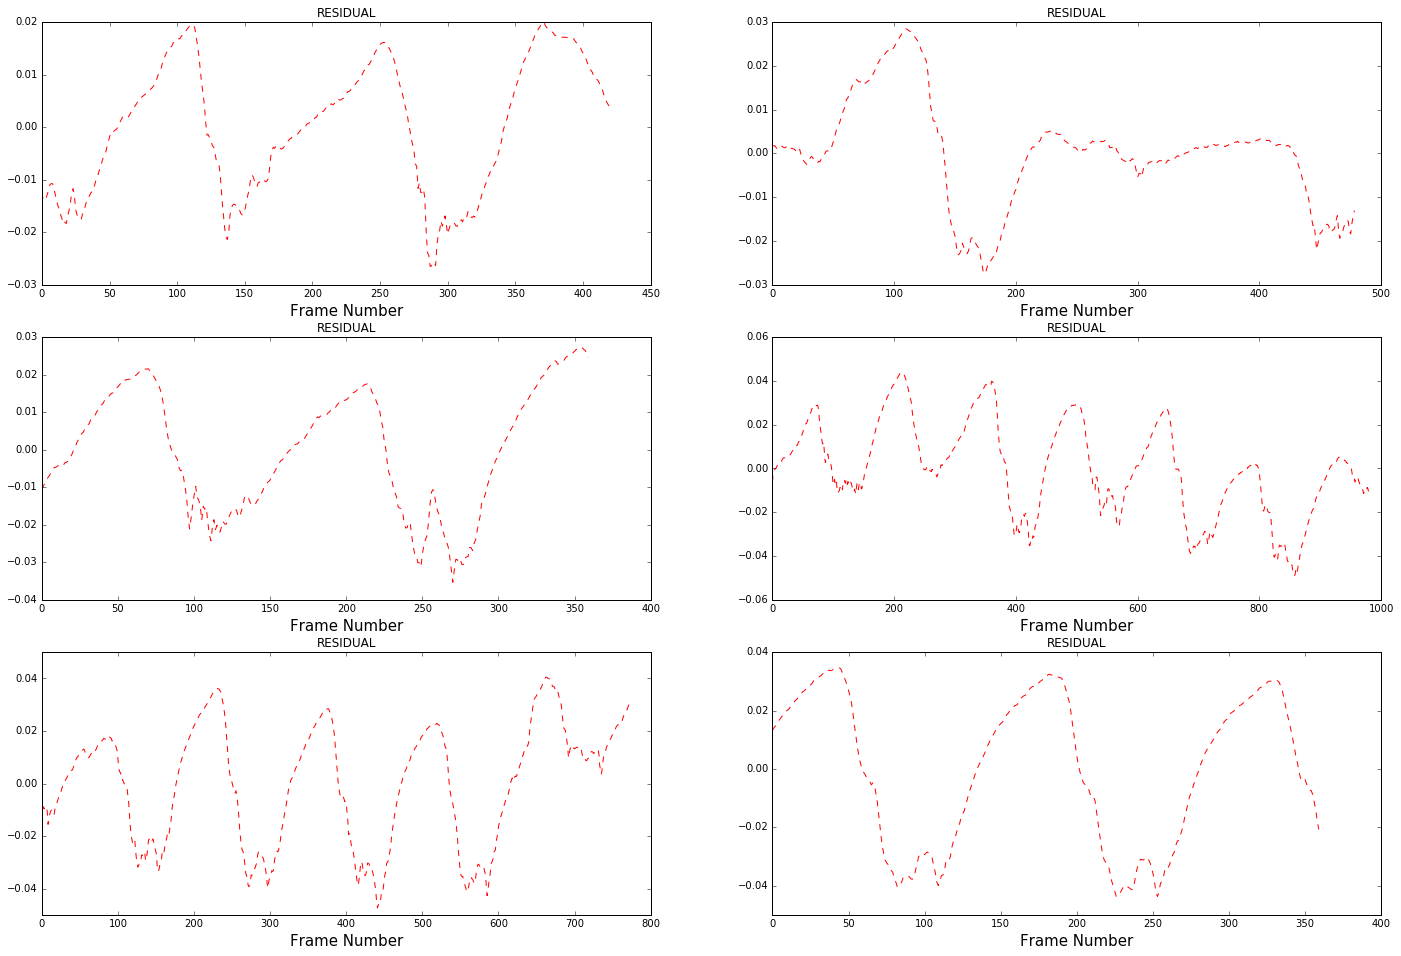

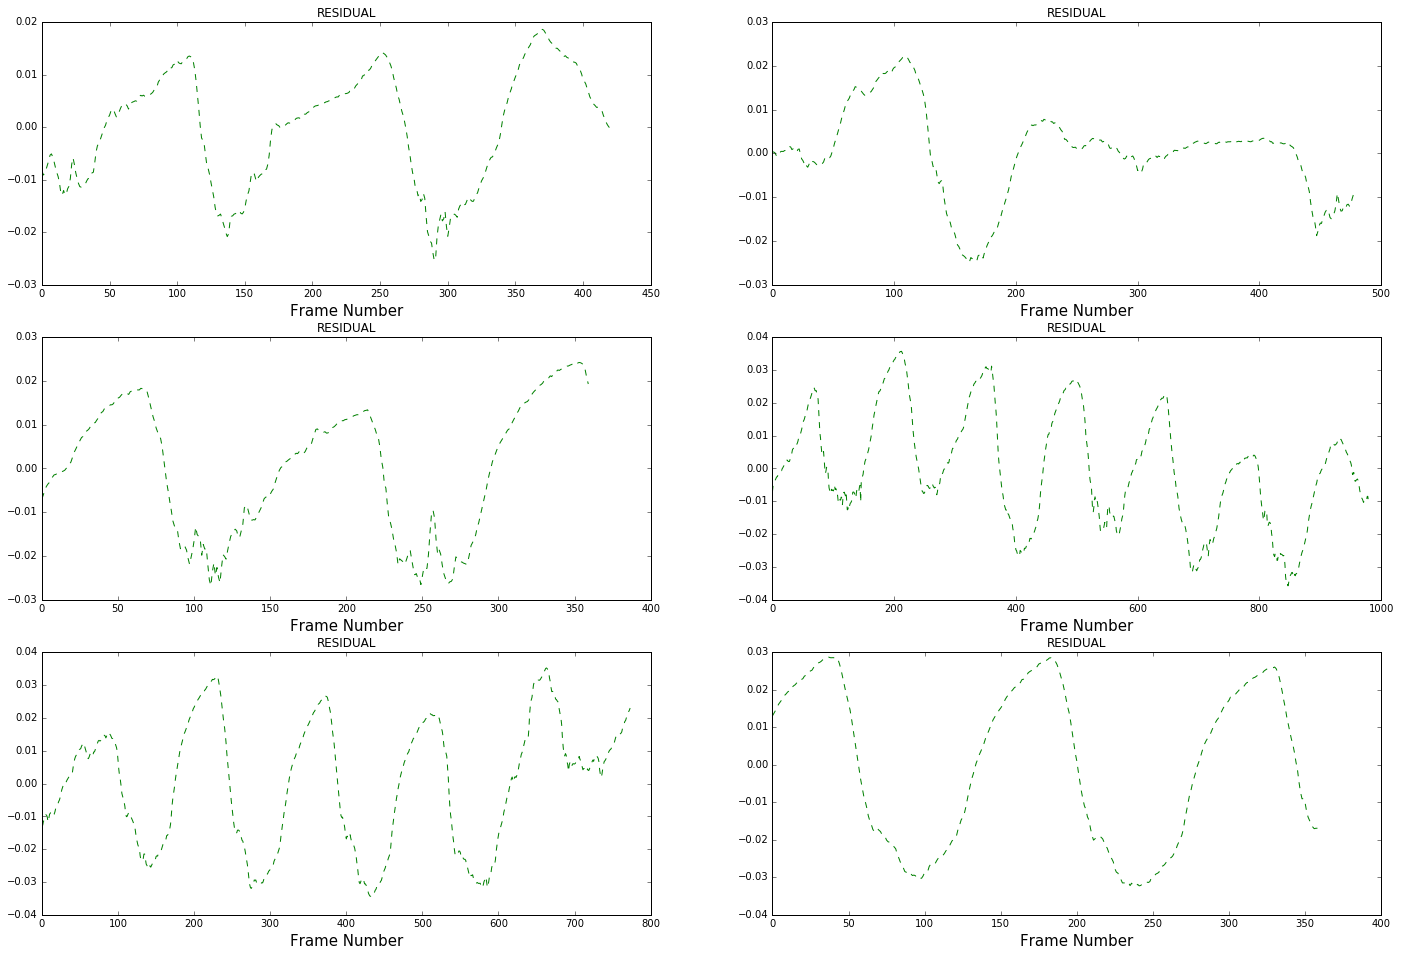

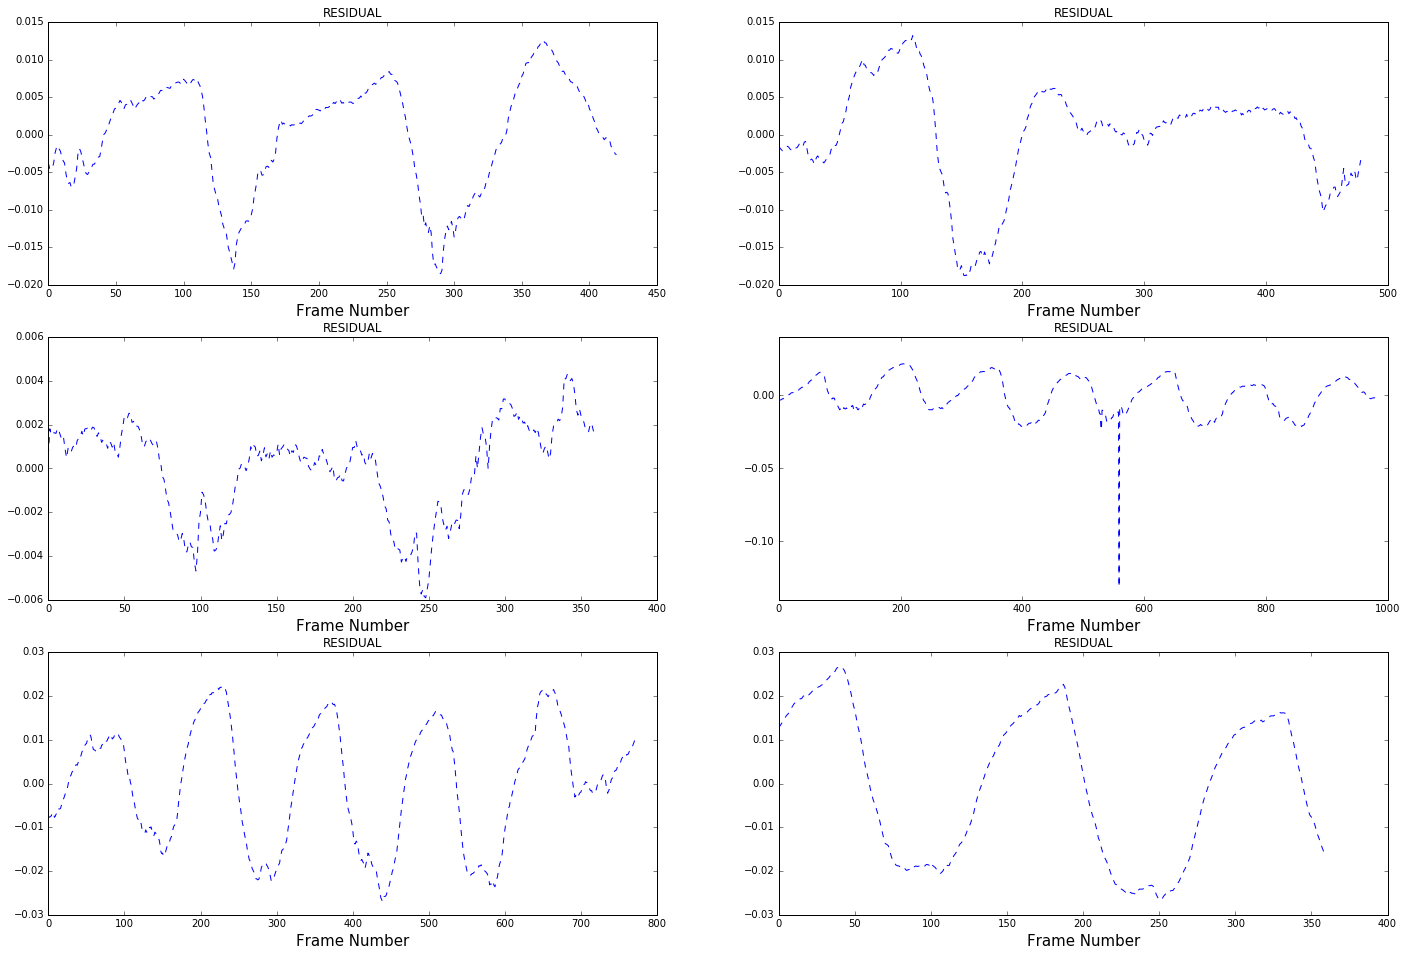

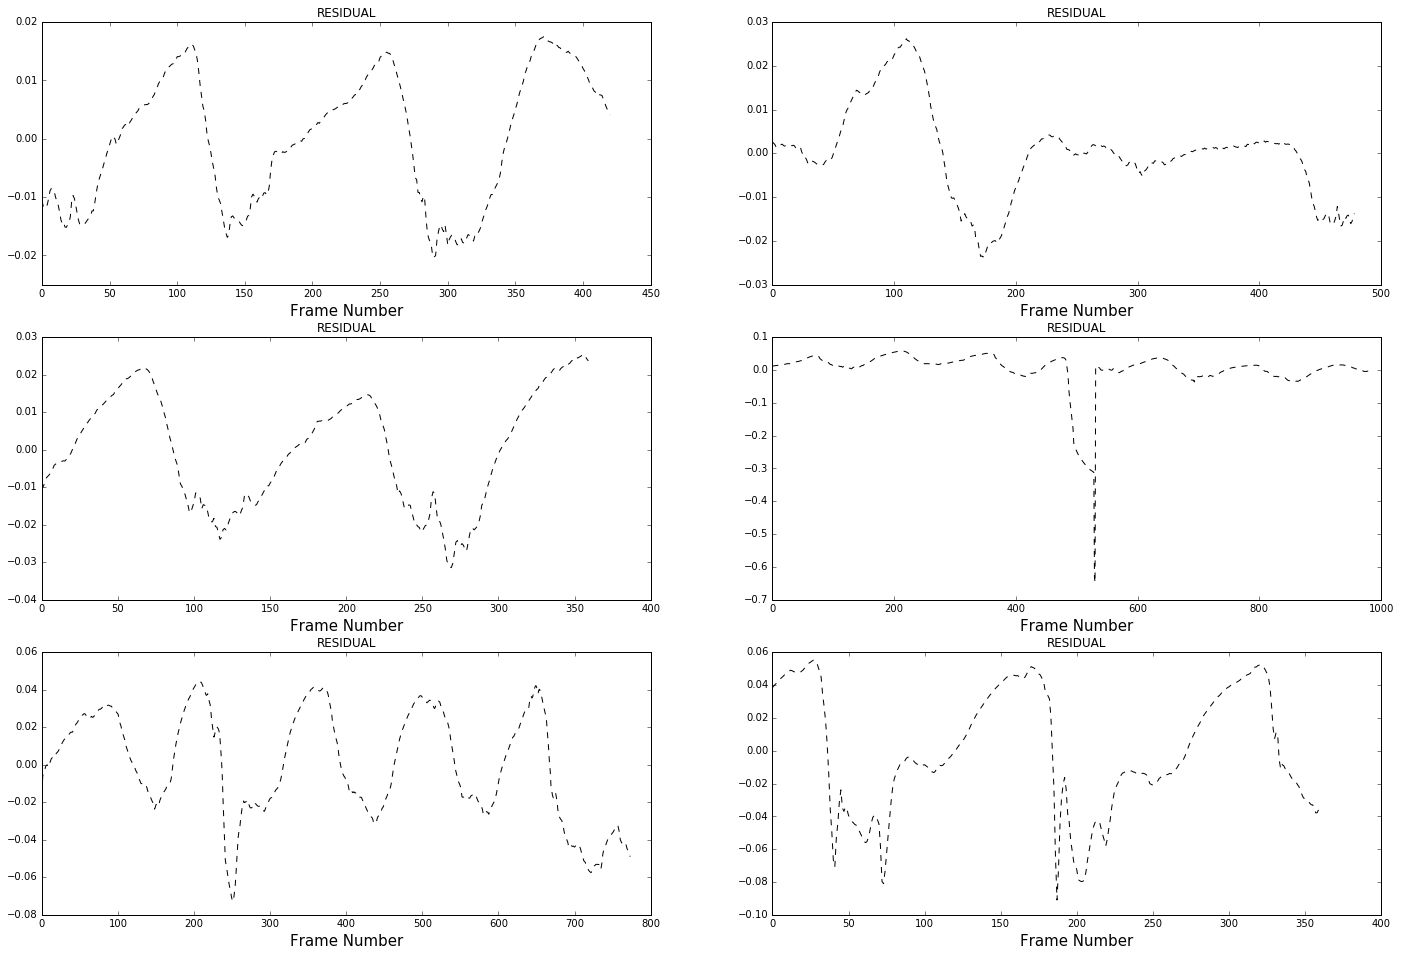

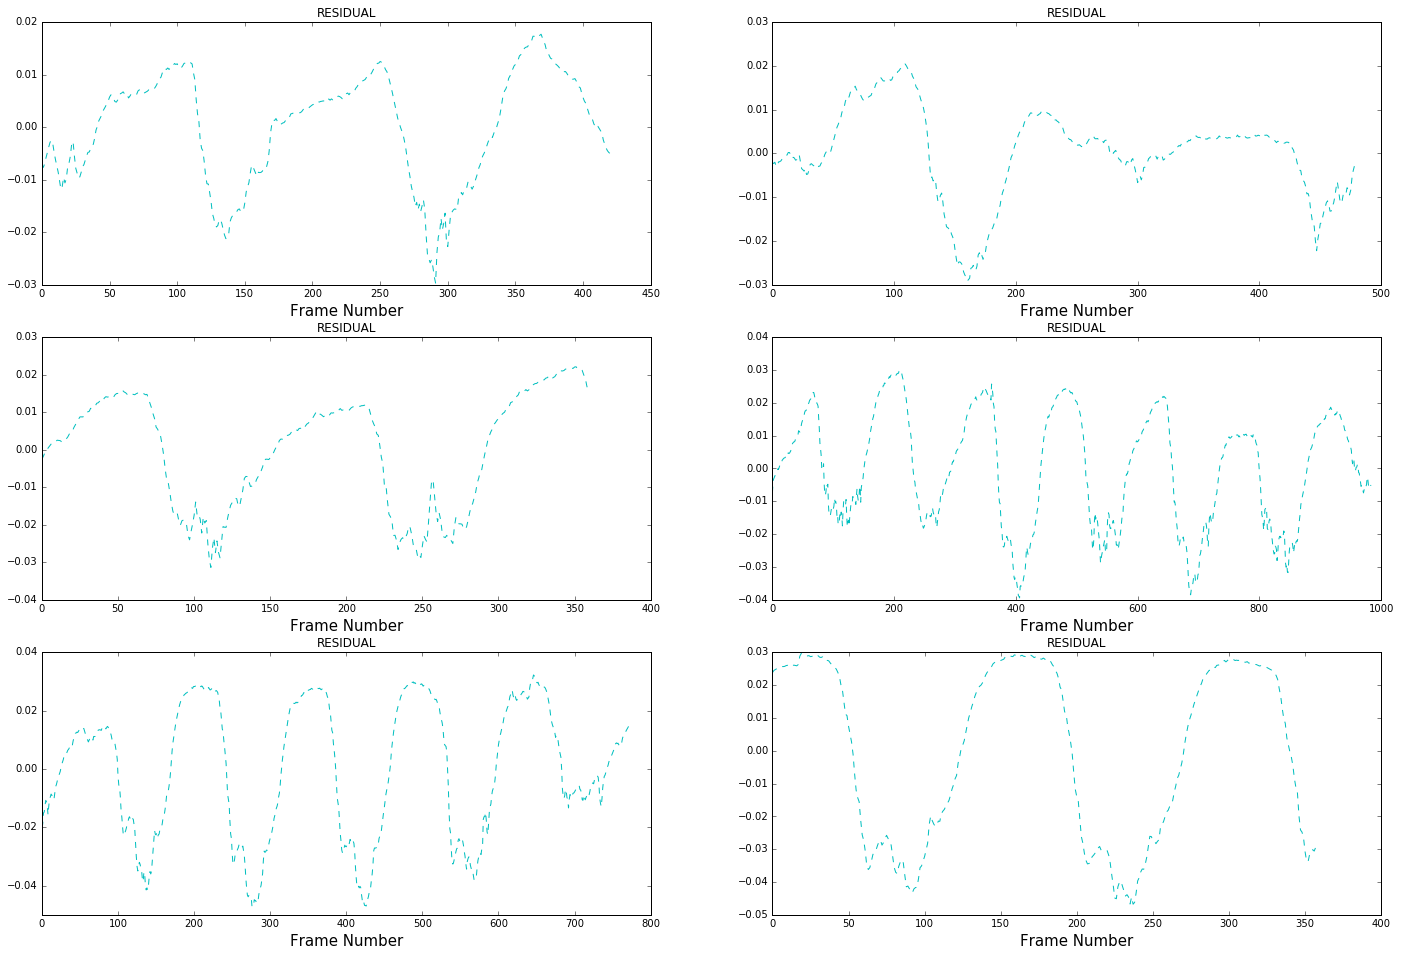

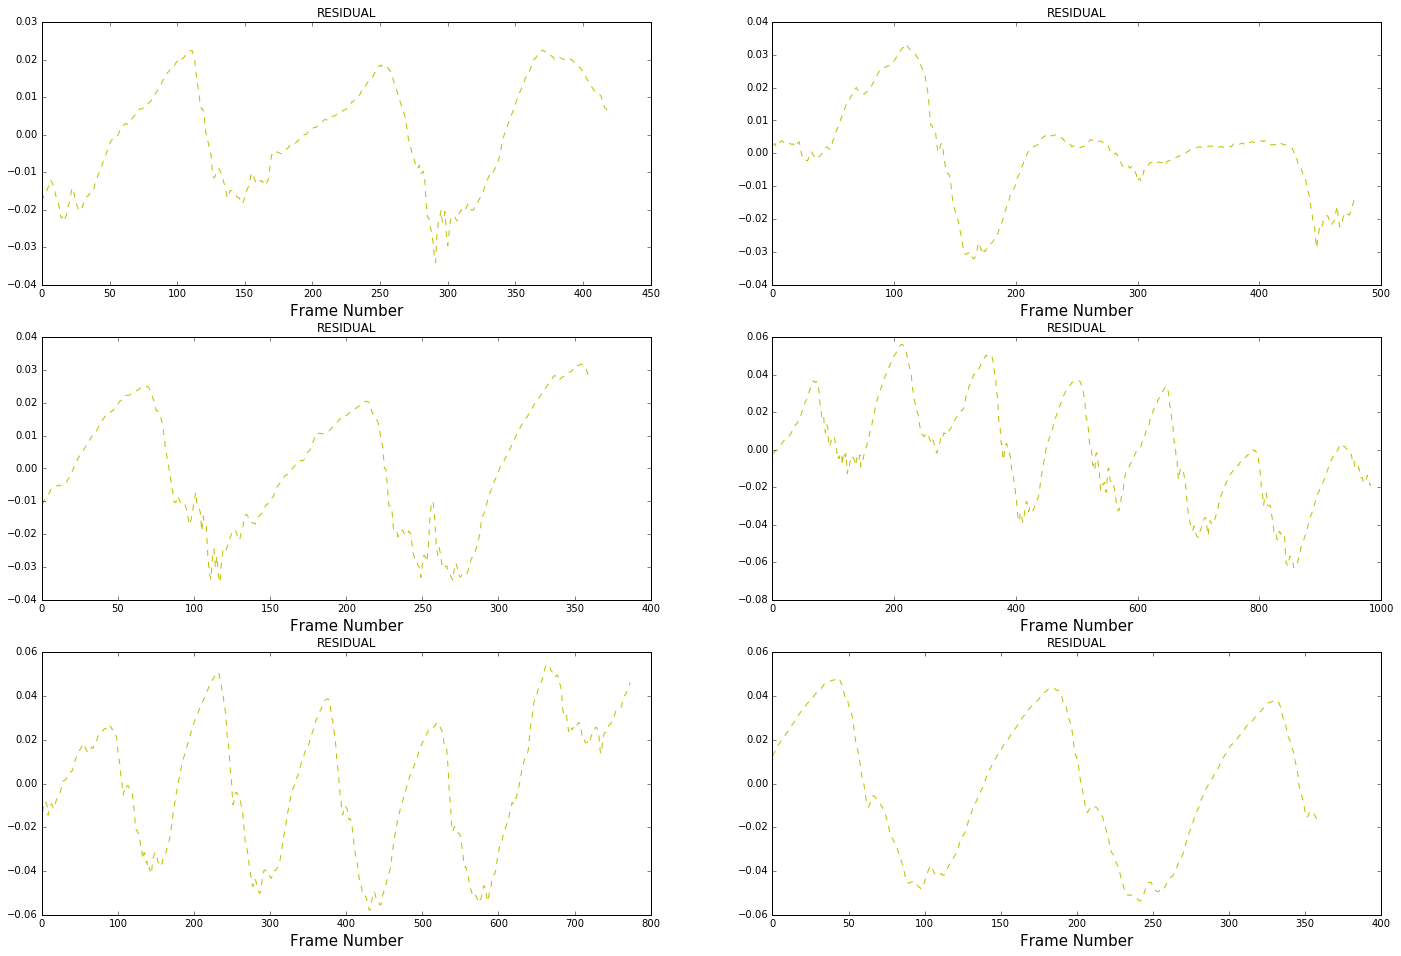

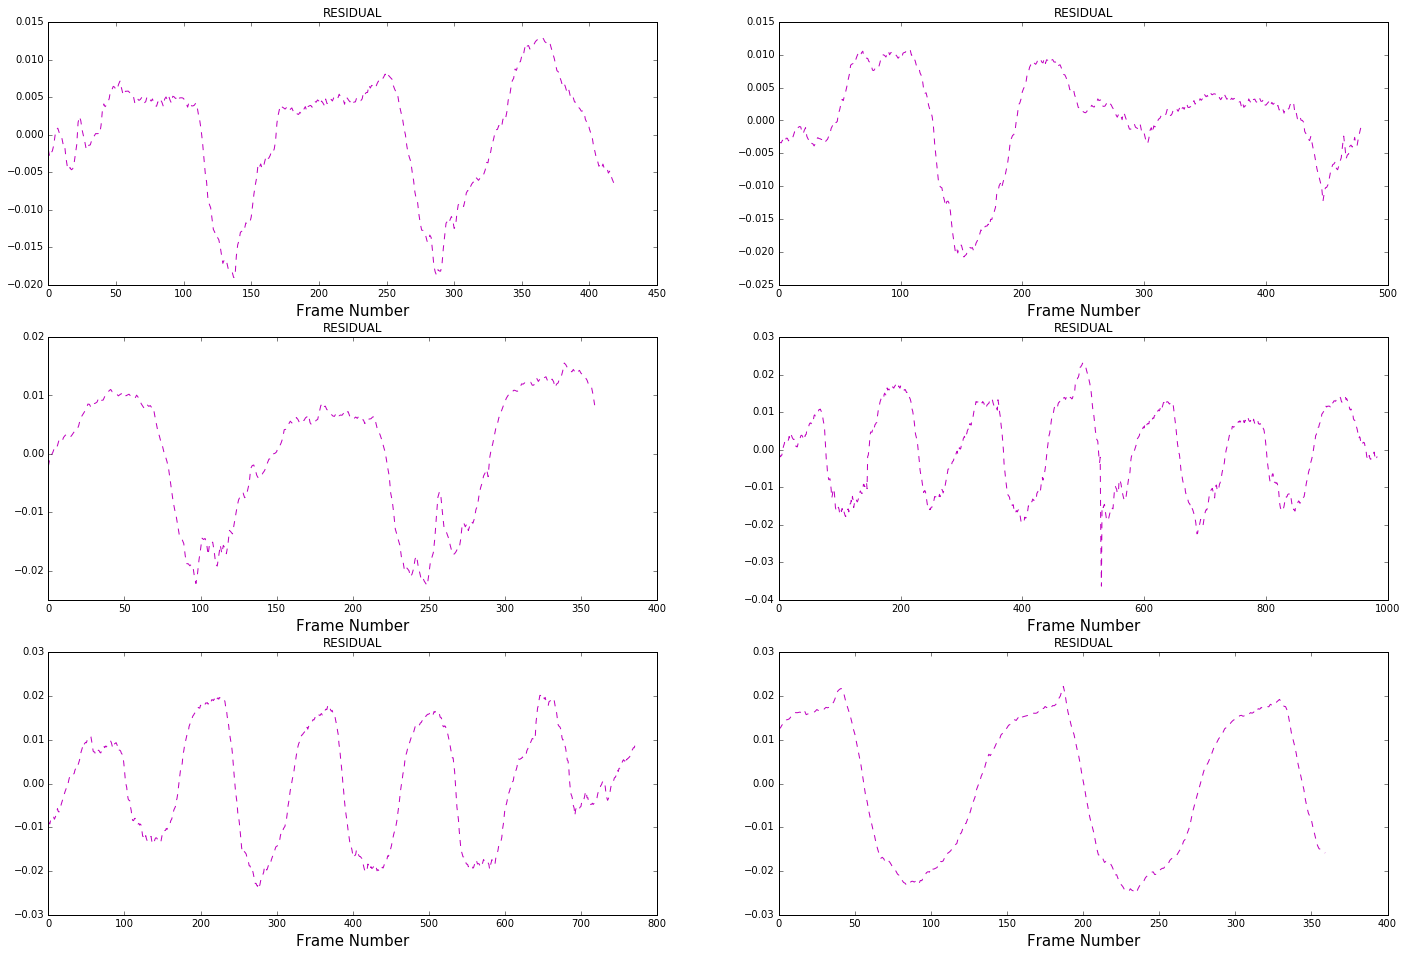

In [310]:
figure(figsize(24,16))
for i in range(len(reflections_generate_all_cable)):
    frame_count=0
    
    
    plt.figure(i+1)
    plt.title('çable number %i' %(i))
    frac_change_gain_per_cable_model = []
    frac_change_gain_per_cable_raw = []
    for k in range(len(reflections_generate_all_cable[i][0])):
        gain_per_frame_600 = np.zeros(frame_per_dir[k])
        gain_per_frame = np.zeros(frame_per_dir[k])
        
        for j in range(frame_per_dir[k]):
            z=np.polyfit(freq_phase[50:990], gain_all[frame_count+j,i,:],1)
            p=np.poly1d(z)
            gain_per_frame = p(freq_phase[50:990]) + reflections_generate_all_cable[i][0][k]
            gain_per_frame_600[j] = gain_per_frame[freq]
        
        plt.subplot(3,2,k+1)
        
        model_frac_change_gain = (gain_per_frame_600-np.mean(gain_per_frame_600))/np.mean(gain_per_frame_600)
        raw_frac_change_gain = (gain_all[frame_count:frame_count+frame_per_dir[k],i,freq]-np.mean(gain_all[frame_count:frame_count+frame_per_dir[k],i,freq]))/np.mean(gain_all[frame_count:frame_count+frame_per_dir[k],i,freq]) 
        frac_change_gain_per_cable_model.append(model_frac_change_gain)
        frac_change_gain_per_cable_raw.append(raw_frac_change_gain)
        '''
        if i ==1:
            print (len(date_time_all[k]))
        '''    
        plt.plot((gain_all[frame_count:frame_count+frame_per_dir[k],i,freq]-np.mean(gain_all[frame_count:frame_count+frame_per_dir[k],i,freq]))/np.mean(gain_all[frame_count:frame_count+frame_per_dir[k],i,freq]),color = colors[i])
        plt.title('RESIDUAL', size =15)
        plt.xlabel('Frame Number')
        
        frame_count=frame_count + frame_per_dir[k]

In [383]:
file = open("temp_data.out","r")
date_temp = np.loadtxt('temp_data.out')
file.close()

In [384]:
from datetime import datetime
from datetime import timedelta
import datetime

temp_need =date_temp[1][::2]
np.append(temp_need,date_temp[1][len(date_temp[1])-1])

time_need_before = date_temp[0]
time_need_all = np.array([ (datetime.datetime.fromtimestamp(x)) 
                    for x in time_need_before ])

time_need = time_need_all[::2]
np.append(time_need,date_temp[1][len(date_temp[0])-1])

print(time_need_all[0:3])
print(time_need_all[len(time_need_all)-1])

[datetime.datetime(2017, 4, 7, 20, 0) datetime.datetime(2017, 4, 7, 20, 5)
 datetime.datetime(2017, 4, 7, 20, 10)]
2017-04-10 18:00:00


In [385]:
print (len(time_need_all[::2]))
print (len(temp_need))
#plt.plot(time_need,temp_need)

421
421


In [451]:
figure(figsize(16,8))
for i in range(len(corr_list)):

    plt.figure(1)
    plt.plot(time_need,gain_all[0:frame_per_dir[0],i,freq]/(temp_need+273) ,'.', color=colors[i], label = 'Linar_gain/Temp Cable # %i' %(i))
    
    if i==1:
        #plt.plot(time_need, temp_need, label = 'Weather data')
        #plt.axvline(x=time_need[338], linewidth=2)
        #plt.axvline(x=time_need[72], linewidth=2)
        #print (gain_all[55:72,i,freq]/temp_need[55:72])

    #legend(loc='best', numpoints=1, fancybox=True)
    plt.xlabel('Time', size =20)
    plt.ylabel('Temp (Deg C) or Gain/Temp', size =20)
 
    '''
    plt.figure(2)
    plt.subplot(4,2,i+1)
    plt.plot(time_need,gain_all[0:frame_per_dir[0],i,freq]/temp_need, color=colors[i])
    
    plt.figure(3)
    plt.plot(time_need,delay[0:frame_per_dir[0],i]/temp_need, color=colors[i], label = 'Delay/Temp Cable # %i' %(i))
    
    legend(loc='best', numpoints=1, fancybox=True)
    plt.xlabel('Time', size =20)
    plt.ylabel('Temp (Deg C) or Delay/Temp', size =20)
    
    plt.figure(4)
    plt.plot(time_need,gain_all[0:frame_per_dir[0],i,freq], color=colors[i])
    plt.xlabel('Time', size =20)
    plt.ylabel('Raw Gain (Linear Scale)', size =20)
    '''

IndentationError: expected an indented block (<ipython-input-451-7dd2b2b571e4>, line 14)

In [427]:
for i in range(len(corr_list)):
    print(i),
    
    print(temp_need[57:60]),
    print(gain_all[57:60,i,freq]/temp_need[57:60])
    
    print(temp_need[203:207]),
    print(gain_all[203:207,i,freq]/temp_need[203:207])
    
    print(temp_need[312:315]),
    print(gain_all[312:315,i,freq]/temp_need[312:315])
    
    print(temp_need[341:344]),
    print(gain_all[341:344,i,freq]/temp_need[341:344])

0
[ 0.05555056  0.          0.49999667]
[ 5.17449658         inf  0.57554611]
[ 0.05555056  0.          0.         -0.33333667]
[ 5.18183029         inf         inf -0.8643842 ]
[-0.16666833 -0.05555889 -0.27777778]
[-1.69452426 -5.08228148 -1.01663691]
[-0.27777778 -0.05555889 -0.11111778]
[-1.03365446 -5.17284281 -2.58837473]
1
[ 0.05555056  0.          0.49999667]
[ 5.04042911         inf  0.56069194]
[ 0.05555056  0.          0.         -0.33333667]
[ 5.04660929         inf         inf -0.84126189]
[-0.16666833 -0.05555889 -0.27777778]
[-1.65043837 -4.95125997 -0.99091964]
[-0.27777778 -0.05555889 -0.11111778]
[-1.00723967 -5.04126232 -2.52239562]
2
[ 0.05555056  0.          0.49999667]
[ 5.501015           inf  0.61151053]
[ 0.05555056  0.          0.         -0.33333667]
[ 5.49719192         inf         inf -0.91642946]
[-0.16666833 -0.05555889 -0.27777778]
[-1.80952237 -5.4294219  -1.08669195]
[-0.27777778 -0.05555889 -0.11111778]
[-1.09891661 -5.49899725 -2.75054336]
3
[ 0.0555

C:\Users\sidhant\Anaconda3\envs\py3k\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sidhant\Anaconda3\envs\py3k\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: divide by zero encountered in true_divide


C:\Users\sidhant\Anaconda3\envs\py3k\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in double_scalars


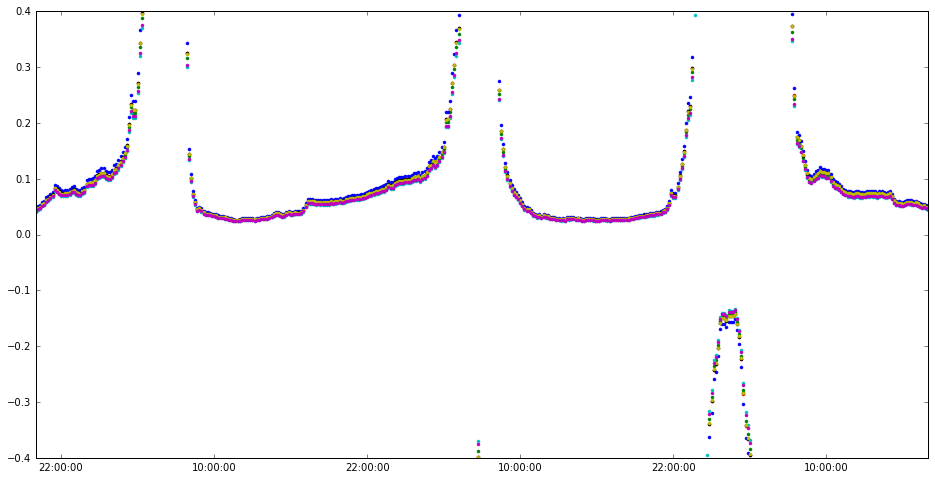

In [444]:
figure(figsize(16,8))
for i in range(len(corr_list)):
    time_new=[]
    fraction =[]
    for j in range(frame_per_dir[0]):
        #print(gain_all[j,i,freq]/temp_need[j])
        if gain_all[j,i,freq]/temp_need[j] >-0.4 and gain_all[j,i,freq]/temp_need[j] < 0.4:
            
            time_new.append(time_need[j])
            fraction.append(gain_all[j,i,freq]/temp_need[j])
    plt.figure(1)
    plt.plot(time_new,fraction ,'.', color=colors[i], label = 'Linar_gain/Temp Cable # %i' %(i))
    #plt.ylim(-0.1,0.1)